<a href="https://colab.research.google.com/github/Wqcapstone1234/Enhancing-Basic-VIX-Strategy/blob/main/MScFE_690_Capstone_Code_Group_9171.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install ta
!pip install hmmlearn
!pip install arch
!pip install yfinance --upgrade
!pip install tensorflow scikit-learn

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=b4aba9f31d0a1975d36ec94d096d0d3d3cbbe50625108132bc74dc4be336a4b0
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 13.7 MB/s eta 0:00:00


In [45]:
#Libraries
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import time

from ta.momentum import RSIIndicator
from arch import arch_model
from statsmodels.tsa.stattools import ccf
from hmmlearn import hmm
import statsmodels.api as sm

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Collection and Preprocessing

In [3]:
start_date = datetime.date(2014, 1, 1)
end_date   = datetime.date(2024, 12, 31)
VOO        = yf.download(['VOO'], start_date, end_date)
VIX        = yf.download(['^VIX'], start_date, end_date)
VOO_close  = VOO[['Close']]
VIX_close  = VIX[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df = pd.concat([VOO['Close'], VIX['Close']],axis=1)
print('Number of missing data:')
print(df.isna().sum())

Number of missing data:
Ticker
VOO     0
^VIX    0
dtype: int64


# Exploratory Data Analysis

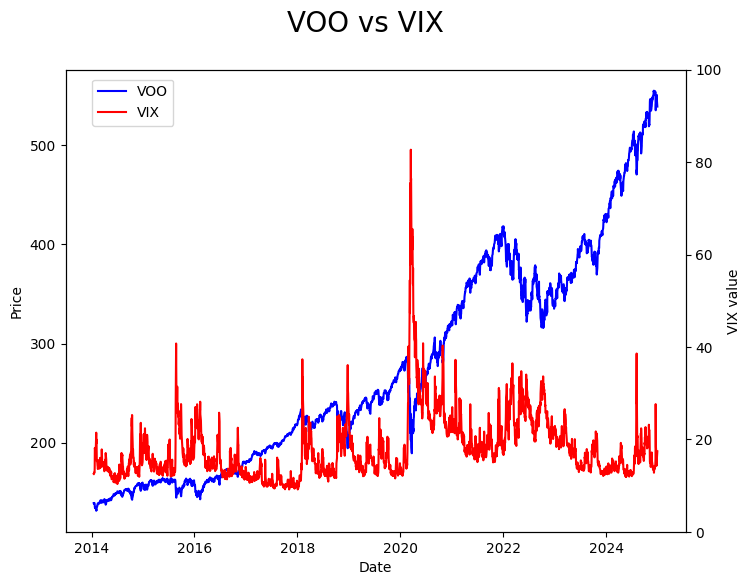

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax2.set_ylim(0, 100)

# Plot lines with labels
ax1.plot(df.index, df['VOO'], color='b', label='VOO')
ax2.plot(df.index, df['^VIX'], color='r', label='VIX')

ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax2.set_ylabel("VIX value")

fig.suptitle("VOO vs VIX", fontsize=20)

# Get legend handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
handles = handles1 + handles2
labels = labels1 + labels2

# Create a single legend for the figure
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 0.875))

# Display the plot
plt.show()


In [6]:
df['VOO pct change'] = df['VOO'].pct_change()
df['VIX pct change'] = df['^VIX'].pct_change()
df['VOO pct change sd'] = df['VOO'].pct_change().rolling(10).std()
df['VIX pct change sd'] = df['^VIX'].pct_change().rolling(10).std()
df = df.dropna()
print(df.head())

Ticker             VOO   ^VIX  VOO pct change  VIX pct change  \
Date                                                            
2014-01-16  138.932175  12.53       -0.001536        0.020358   
2014-01-17  138.331833  12.44       -0.004321       -0.007183   
2014-01-21  138.767670  12.87        0.003151        0.034566   
2014-01-22  138.849899  12.84        0.000593       -0.002331   
2014-01-23  137.731506  13.77       -0.008055        0.072430   

Ticker      VOO pct change sd  VIX pct change sd  
Date                                              
2014-01-16           0.006223           0.047654  
2014-01-17           0.006418           0.047062  
2014-01-21           0.006377           0.048931  
2014-01-22           0.006110           0.046615  
2014-01-23           0.006677           0.051803  


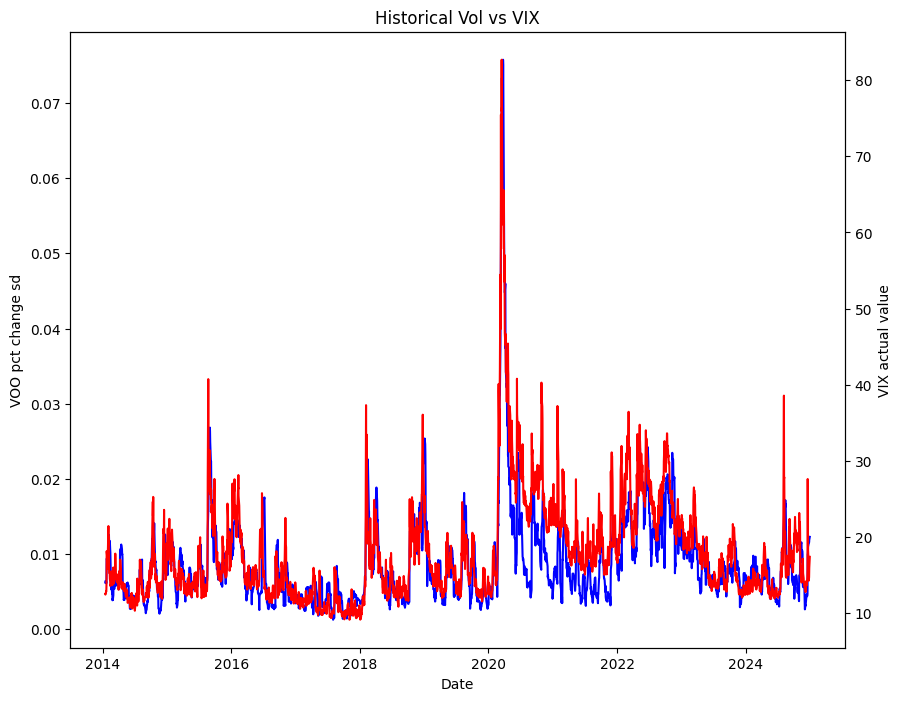

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()
ax1.plot(df.index,df['VOO pct change sd'],color ='b')
ax2.plot(df.index, df['^VIX'],color = 'r')


ax1.set_xlabel("Date")
ax1.set_ylabel("VOO pct change sd")
ax2.set_ylabel("VIX actual value")



plt.title("Historical Vol vs VIX")

#fig.suptitle("VOO pct change sd vs VIX actual value", fontsize=12)
plt.show()

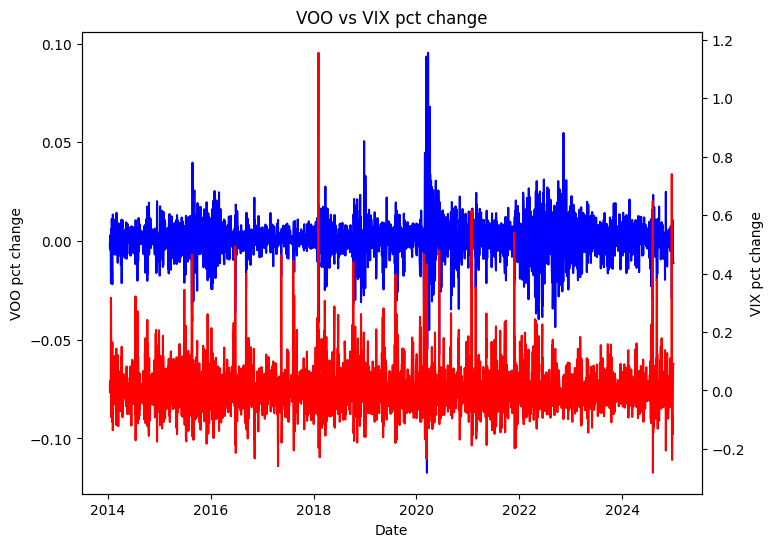

In [8]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(df.index,df['VOO pct change'],color ='b')
ax2.plot(df.index, df['VIX pct change'],color = 'r')


ax1.set_xlabel("Date")
ax1.set_ylabel("VOO pct change")
ax2.set_ylabel("VIX pct change")

plt.title("VOO vs VIX pct change")
plt.show()

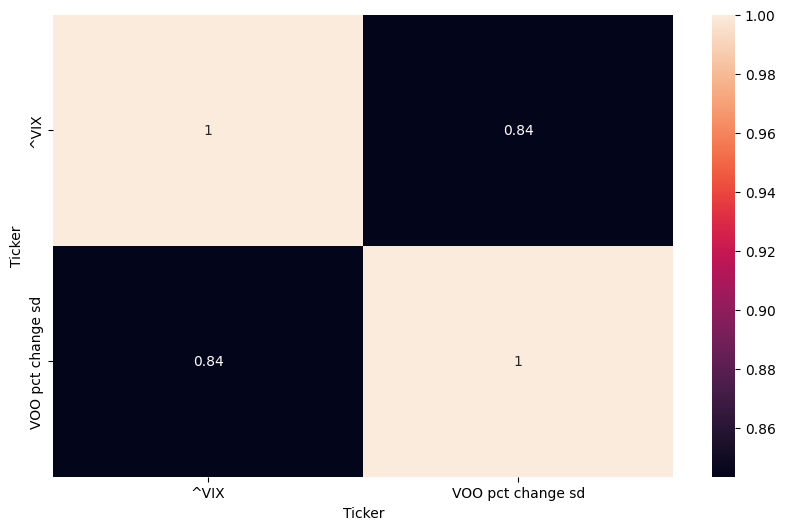

In [9]:
#Plot correlation matrix for all variables
df_corr_1 = df[['^VIX','VOO pct change sd']]
plt.figure(figsize=(10,6))
c = df_corr_1.corr()
sns.heatmap(c, annot=True)
plt.show()

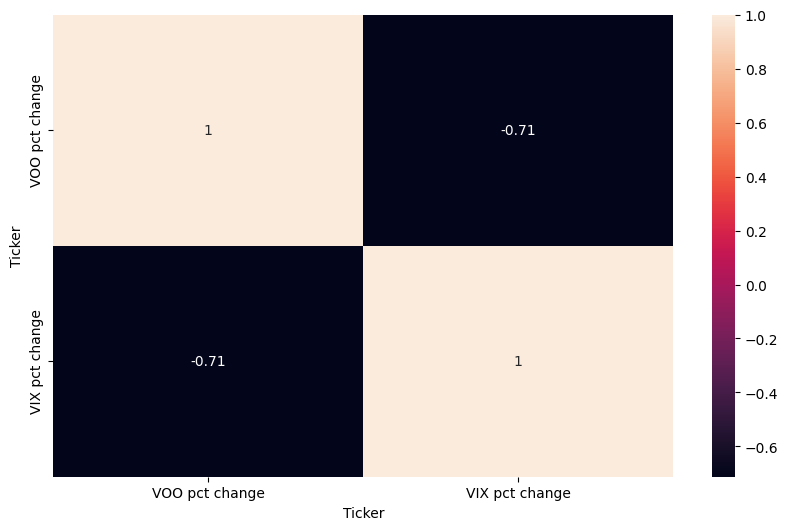

In [10]:
#Plot correlation matrix for all variables
df_corr_2 = df[['VOO pct change','VIX pct change']]
plt.figure(figsize=(10,6))
c = df_corr_2.corr()
sns.heatmap(c, annot=True)
plt.show()

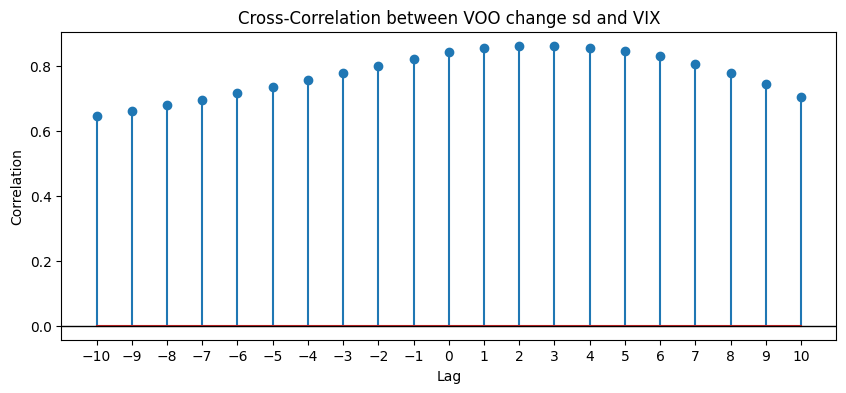

In [11]:
max_lag = 10

# Calculate cross-correlation
lags = np.arange(-10, 11)
cross_corrs = [df['VOO pct change sd'].corr(df['^VIX'].shift(lag)) for lag in lags]

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.stem(lags, cross_corrs)
plt.axhline(0, color='black', lw=1)
plt.xticks(np.arange(-max_lag, max_lag + 1, 1))
plt.title('Cross-Correlation between VOO change sd and VIX')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

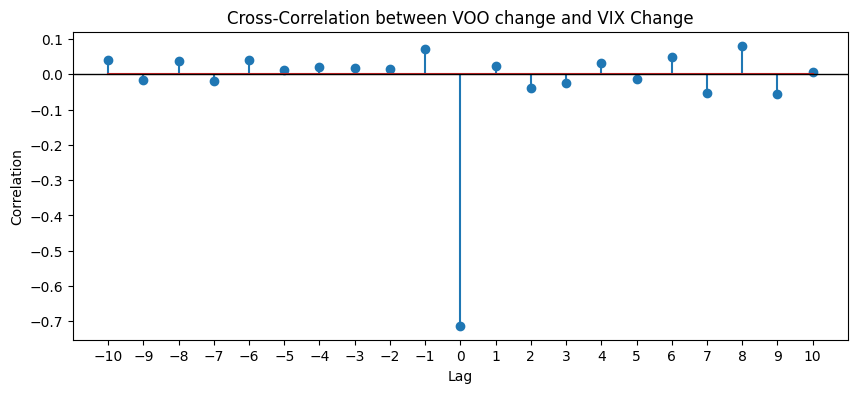

In [12]:
max_lag = 10

# Calculate cross-correlation
lags = np.arange(-10, 11)
cross_corrs = [df['VOO pct change'].corr(df['VIX pct change'].shift(lag)) for lag in lags]

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.stem(lags, cross_corrs)
plt.axhline(0, color='black', lw=1)
plt.xticks(np.arange(-max_lag, max_lag + 1, 1))
plt.title('Cross-Correlation between VOO change and VIX Change')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

# Regime Analysis on the VIX level

In [34]:
# Ensure ^VIX column has no NaNs before fitting
df = df.dropna(subset=['^VIX']).copy()

# Use VIX values from df directly
vix_values = df['^VIX'].values

# Discretize VIX for HMM input
vix_discretized = np.digitize(vix_values, bins=np.linspace(vix_values.min(), vix_values.max(), 20)).reshape(-1, 1)

# Fit HMM model
model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=10000)
model.fit(vix_discretized)
hidden_states = model.predict(vix_discretized)

# Assign regime back to df by position
df['Regime'] = hidden_states

# Calculate percentiles within each regime using the same vix_values
regime_0_vix_mean = np.percentile(vix_values[hidden_states == 0], 10)
regime_1_vix_mean = np.percentile(vix_values[hidden_states == 1], 90)

print(f"Regime 0 VIX (10th percentile): {regime_0_vix_mean:.2f}")
print(f"Regime 1 VIX (90th percentile): {regime_1_vix_mean:.2f}")


Regime 0 VIX (10th percentile): 17.43
Regime 1 VIX (90th percentile): 16.11


# GARCH model analysis

In [14]:
#Define possible value of paramtere p and q for the GARCH model
p_range = range(1, 5)
q_range = range(1, 5)
min_bic = 1e8
selected_orders = (0, 0)

#Run a for-loop for GARCH model to select the p and q paramter with BIC
for p in p_range:
    for q in q_range:
        # GARCH(p,q) model
        model = arch_model(
            df['VIX pct change'],
            mean='Zero',
            vol='GARCH',
            p=p, q=q,
            rescale=True,
            )
        res = model.fit(disp='off')
        print(f'GARCH({p},{q}) AIC: {round(res.aic,4)}, BIC: {round(res.bic,4)}')
        if res.bic < min_bic:
            min_bic = res.bic
            selected_orders = (p, q)
p, q = selected_orders
print(f'Selected model with BIC : p={p} and q={q}')


GARCH(1,1) AIC: 6566.1031, BIC: 6583.8688
GARCH(1,2) AIC: 6568.1031, BIC: 6591.7907
GARCH(1,3) AIC: 6570.1031, BIC: 6599.7126
GARCH(1,4) AIC: 6572.1031, BIC: 6607.6345
GARCH(2,1) AIC: 6567.9991, BIC: 6591.6867
GARCH(2,2) AIC: 6569.6449, BIC: 6599.2544
GARCH(2,3) AIC: 6571.5743, BIC: 6607.1057
GARCH(2,4) AIC: 6573.5743, BIC: 6615.0276
GARCH(3,1) AIC: 6569.9991, BIC: 6599.6086
GARCH(3,2) AIC: 6571.6449, BIC: 6607.1763
GARCH(3,3) AIC: 6573.5136, BIC: 6614.9669
GARCH(3,4) AIC: 6575.5136, BIC: 6622.8888
GARCH(4,1) AIC: 6570.4387, BIC: 6605.9701
GARCH(4,2) AIC: 6572.3563, BIC: 6613.8096
GARCH(4,3) AIC: 6573.6475, BIC: 6621.0227
GARCH(4,4) AIC: 6575.6475, BIC: 6628.9446
Selected model with BIC : p=1 and q=1


In [15]:
#Run a for-loop for GARCH model to select the p and q paramter with BIC
for p in p_range:
    for q in q_range:
        # GARCH(p,q) model
        model = arch_model(
            df['VIX pct change'],
            mean='Zero',
            vol='GARCH',
            p=p, q=q,
            dist="StudentsT",
            rescale=True,
            )
        res = model.fit(disp='off')
        print(f'GARCH({p},{q}) AIC: {round(res.aic,4)}, BIC: {round(res.bic,4)}')
        if res.bic < min_bic:
            min_bic = res.bic
            selected_orders = (p, q)
p, q = selected_orders
print(f'Selected model with BIC : p={p} and q={q}')

GARCH(1,1) AIC: 5912.4911, BIC: 5936.1786
GARCH(1,2) AIC: 5914.4911, BIC: 5944.1005
GARCH(1,3) AIC: 5916.4683, BIC: 5951.9997
GARCH(1,4) AIC: 5918.2673, BIC: 5959.7206
GARCH(2,1) AIC: 5913.7774, BIC: 5943.3869
GARCH(2,2) AIC: 5914.4234, BIC: 5949.9548
GARCH(2,3) AIC: 5916.3164, BIC: 5957.7697
GARCH(2,4) AIC: 5917.6533, BIC: 5965.0285
GARCH(3,1) AIC: 5915.7774, BIC: 5951.3088
GARCH(3,2) AIC: 5916.4234, BIC: 5957.8767
GARCH(3,3) AIC: 5918.3164, BIC: 5965.6916
GARCH(3,4) AIC: 5919.6479, BIC: 5972.945
GARCH(4,1) AIC: 5917.7774, BIC: 5959.2307
GARCH(4,2) AIC: 5918.4234, BIC: 5965.7986
GARCH(4,3) AIC: 5920.3164, BIC: 5973.6134
GARCH(4,4) AIC: 5921.5649, BIC: 5980.7838
Selected model with BIC : p=1 and q=1


In [16]:
# GARCH(1,1) Model with Student's t White Noise
garch11_t_spec = arch_model(
    df['VIX pct change'],
    vol="GARCH",
    p=1,
    q=1,
    mean="AR",
    dist="StudentsT",  # power=2.0,
    rescale=True,
)
garch11_t_fit = garch11_t_spec.fit()
garch11_t_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 89845.06551268202
Iteration:      2,   Func. Count:     19,   Neg. LLF: 41632.65941002648
Iteration:      3,   Func. Count:     26,   Neg. LLF: 5591.985444021311
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4136.799302115984
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3333.9109013577026
Iteration:      6,   Func. Count:     48,   Neg. LLF: 2964.5012896845606
Iteration:      7,   Func. Count:     55,   Neg. LLF: 2948.9520209041148
Iteration:      8,   Func. Count:     62,   Neg. LLF: 4075.9901519724935
Iteration:      9,   Func. Count:     70,   Neg. LLF: 2945.5260004107436
Iteration:     10,   Func. Count:     77,   Neg. LLF: 2945.086403795038
Iteration:     11,   Func. Count:     83,   Neg. LLF: 2945.0819986914303
Iteration:     12,   Func. Count:     89,   Neg. LLF: 2945.081966763639
Iteration:     13,   Func. Count:     95,   Neg. LLF: 2945.08196444775
Iteration:     14,   Func. Count:    100,   Neg. LLF: 2945.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:               VIX pct change   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2945.08
Distribution:      Standardized Student's t   AIC:                           5900.16
Method:                  Maximum Likelihood   BIC:                           5929.77
                                              No. Observations:                 2757
Date:                      Wed, May 21 2025   Df Residuals:                     2756
Time:                              14:33:55   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const         -0.0432  1.171e-02     -3.691  2.237e-04 [-6.619e-02,-2.027e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1010  2.225e-02      4.539  5.646e-06 [5.740e-02,  0.145]
alpha[1]       0.1947  3.985e-02      4.884  1.039e-06   [  0.117,  0.273]
beta[1]        0.6816  5.181e-02     13.158  1.539e-39   [  0.580,  0.783]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.6476      0.286     12.757  2.847e-37 [  3.087,  4.208]
========================================================================

Covariance estimator: robust
"""

In [17]:
# GARCH(1,1) Model with Student's t White Noise
garch11_t_spec = arch_model(
    df['VOO pct change'],
    vol="GARCH",
    p=1,
    q=1,
    mean="AR",
    dist="StudentsT",  # power=2.0,
    rescale=False,
)
df['GARCH predict'] = np.nan
win_size = 20
for pos in range(len(df) - win_size):
  try:
    model_fit = garch11_t_spec.fit(first_obs=pos, last_obs=pos+win_size, disp="off")
    pred = model_fit.forecast(reindex=False,horizon=1, method="analytic")
    df.iloc[pos + win_size, df.columns.get_loc('GARCH predict')] = np.sqrt(pred.variance.iloc[-1].values[0])
  except Exception as e:
    print(f"Error at position {pos}: {e}")
    continue
df['GARCH predict shift 1'] = df['GARCH predict'].shift(1)
df['GARCH Signal'] = np.where(df['GARCH predict shift 1'] > df['VOO pct change sd'], 1, 0)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-package

In [18]:
df['GARCH predict shift 1'] = df['GARCH predict'].shift(1)

# Feature Engineering

In [ ]:
# df['VIX lag 1']    = df['^VIX'].shift(1)
# df['VIX SMA 20']   = df['^VIX'].rolling(20).mean()
# #df['buy signal']  = df['^VIX'] < df['VIX SMA 20']
# #df['sell signal'] = df['^VIX'] > df['VIX SMA 20']
# #print(df.tail())

# RSI

In [19]:
df ['VOO RSI 7']        = RSIIndicator(close = df['VOO'], window =7).rsi()
df ['VIX RSI 7']        = RSIIndicator(close = df['^VIX'], window =7).rsi()
df ['VOO RSI 14']       = RSIIndicator(close = df['VOO'], window =14).rsi()
df ['VIX RSI 14']       = RSIIndicator(close = df['^VIX'], window =14).rsi()
df ['VOO RSI 35']       = RSIIndicator(close = df['VOO'], window =35).rsi()
df ['VIX RSI 35']       = RSIIndicator(close = df['^VIX'], window =35).rsi()
df ['VOO RSI 7 - 35']   = df ['VOO RSI 7'] - df ['VOO RSI 35']
df ['VIX RSI 7 - 35']   = df ['VIX RSI 7'] - df ['VIX RSI 35']

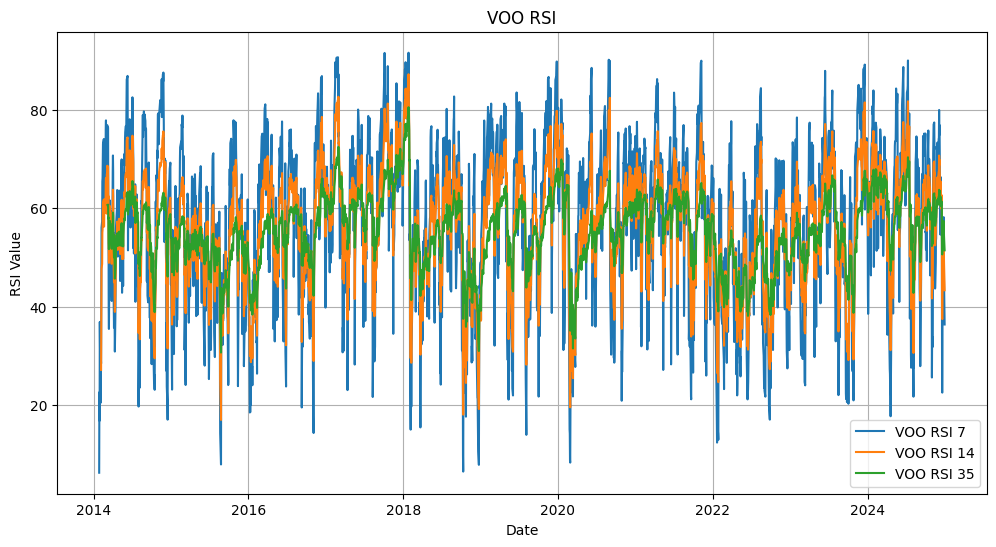

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['VOO RSI 7'], label='VOO RSI 7')
plt.plot(df.index, df['VOO RSI 14'], label='VOO RSI 14')
plt.plot(df.index, df['VOO RSI 35'], label='VOO RSI 35')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.title('VOO RSI')
plt.legend()
plt.grid(True)
plt.show()


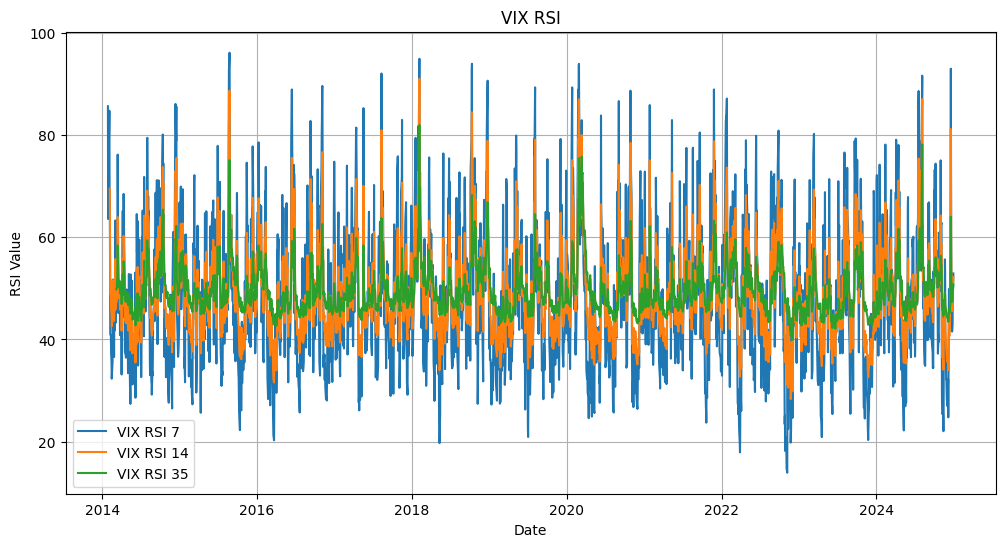

In [21]:

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['VIX RSI 7'], label='VIX RSI 7')
plt.plot(df.index, df['VIX RSI 14'], label='VIX RSI 14')
plt.plot(df.index, df['VIX RSI 35'], label='VIX RSI 35')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.title('VIX RSI')
plt.legend()
plt.grid(True)
plt.show()


# Backtesting for VIX-only baseline Strategy

In [23]:
def backtest_base(df,buy_threshold, sell_threshold):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > buy_threshold : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
          trade_count += 1
      elif df.loc[i,'^VIX'] < sell_threshold : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
          trade_count += 1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'].iloc[-1] - 1) * 100

  return {
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': trade_count
  }

In [24]:
metrics_VIX = []

buy_threshold_range = [10, 20, 30, 40, 50]
sell_threshold_range = [10, 20, 30, 40, 50]
for buy_threshold in buy_threshold_range:
  for sell_threshold in sell_threshold_range:
    metrics_VIX.append(backtest_base(df,buy_threshold, sell_threshold))

summary_VIX_df = pd.DataFrame(metrics_VIX)
summary_VIX_df.index.name = None
print(summary_VIX_df)
summary_VIX_df.to_csv('metrics_VIX.csv')

# Backtesting for VIX+RSI hybrid Strategy

In [25]:
def backtest_RSI(df,buy_threshold, sell_threshold, RSI_buy_threshold, RSI_sell_threshold):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > buy_threshold and df.loc[i,'VIX RSI 14'] > RSI_buy_threshold : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
          trade_count += 1
      elif df.loc[i,'^VIX'] < sell_threshold and df.loc[i,'VIX RSI 14']  < RSI_sell_threshold: # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
          trade_count += 1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'].iloc[-1] - 1) * 100

  return {
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'RSI_buy_threshold': RSI_buy_threshold,
        'RSI_sell_threshold': RSI_sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': trade_count
  }

In [26]:
metrics_VIX_RSI = []

buy_threshold_range = [10, 20, 30, 40, 50]
sell_threshold_range = [10, 20, 30, 40, 50]
RSI_buy_threshold_range = [10, 30, 50, 70]
RSI_sell_threshold_range = [10, 30, 50, 70]
for buy_threshold in buy_threshold_range:
  for sell_threshold in sell_threshold_range:
    for RSI_buy_threshold in RSI_buy_threshold_range:
      for RSI_sell_threshold in RSI_sell_threshold_range:
        metrics_VIX_RSI.append(backtest_RSI(df, buy_threshold, sell_threshold, RSI_buy_threshold, RSI_sell_threshold))

metrics_VIX_RSI_df = pd.DataFrame(metrics_VIX_RSI)
metrics_VIX_RSI_df.index.name = None
print(metrics_VIX_RSI_df)
metrics_VIX_RSI_df.to_csv('metrics_VIX_RSI.csv')

     buy_threshold  sell_threshold  RSI_buy_threshold  RSI_sell_threshold  \
0               10              10                 10                  10   
1               10              10                 10                  30   
2               10              10                 10                  50   
3               10              10                 10                  70   
4               10              10                 30                  10   
..             ...             ...                ...                 ...   
395             50              50                 50                  70   
396             50              50                 70                  10   
397             50              50                 70                  30   
398             50              50                 70                  50   
399             50              50                 70                  70   

    Total Return Sharpe Ratio Max Drawdown  Trades  
0        308.66%      

# Trading Strategy based on VIX level

In [ ]:
def backtest_1(df):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)
  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)

  num_of_buy = 0
  num_of_sell = 0

  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values

      if df.loc[i,'^VIX'] > 40 : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
          num_of_buy += 1
      elif df.loc[i,'^VIX'] < 10 : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
          num_of_sell += 1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  # Plot cumulative returns
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
  plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.title('Backtest Results')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
  #Sharpe Ratio
  strategy_sharpe_ratio = df['Strategy_Returns'].mean() / df['Strategy_Returns'].std() * np.sqrt(252)
  buy_and_hold_sharpe_ratio = df['VOO'].pct_change().mean() / df['VOO'].pct_change().std() * np.sqrt(252)

  #Number of Trade
  num_of_trade = df['Position'].sum()

  print(f"Total Strategy Return: {strategy_total_return:.2f}%")
  print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

  print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
  print(f"Buy and Hold Sharpe Ratio: {buy_and_hold_sharpe_ratio:.2f}")
  print(f"Number of buy: {num_of_buy:.0f}")
  print(f"Number of sell: {num_of_sell:.0f}")
  #Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

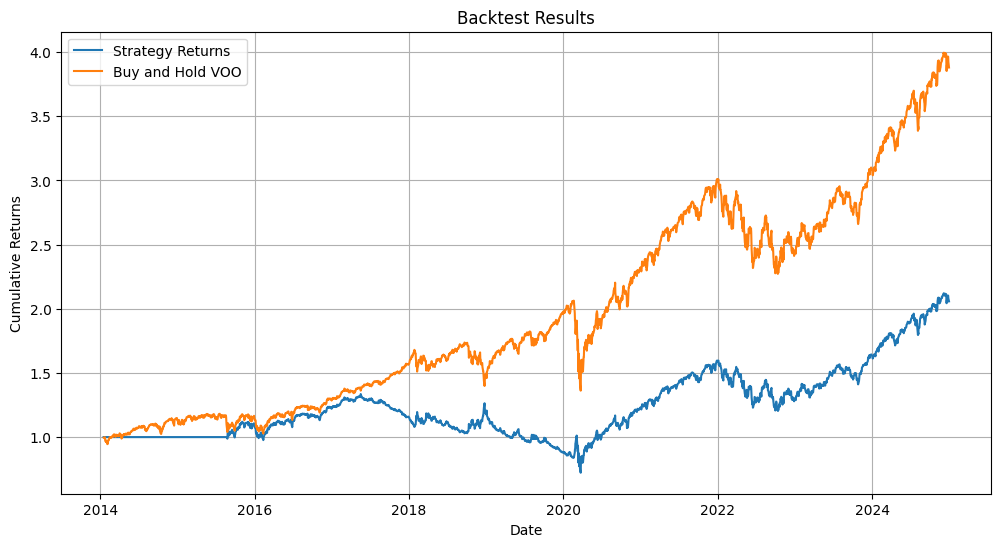

Total Strategy Return: 105.79%
Total Buy and Hold VOO Return: 288.05%
Strategy Sharpe Ratio: 0.48
Buy and Hold Sharpe Ratio: 0.80
Number of buy: 36
Number of sell: 59


<ipython-input-26-97b5aa489eb0>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-26-97b5aa489eb0>:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
backtest_1(df)

In [ ]:
def backtest_2(df):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)
  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)

  num_of_buy = 0
  num_of_sell = 0

  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values

      if df.loc[i,'^VIX'] > 40 and df.loc[i,'VOO RSI 35'] < 30 : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
          num_of_buy += 1
      elif df.loc[i,'^VIX'] < 10 and df.loc[i,'VOO RSI 35'] > 70: # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
          num_of_sell += 1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  # Plot cumulative returns
  plt.figure(figsize=(12, 6))
  plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
  plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Returns')
  plt.title('Backtest Results')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
  #Sharpe Ratio
  strategy_sharpe_ratio = df['Strategy_Returns'].mean() / df['Strategy_Returns'].std() * np.sqrt(252)

  #Number of Trade
  num_of_trade = df['Position'].sum()

  print(f"Total Strategy Return: {strategy_total_return:.2f}%")
  print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

  print(f"Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
  print(f"Number of buy: {num_of_buy:.0f}")
  print(f"Number of sell: {num_of_sell:.0f}")
  #Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

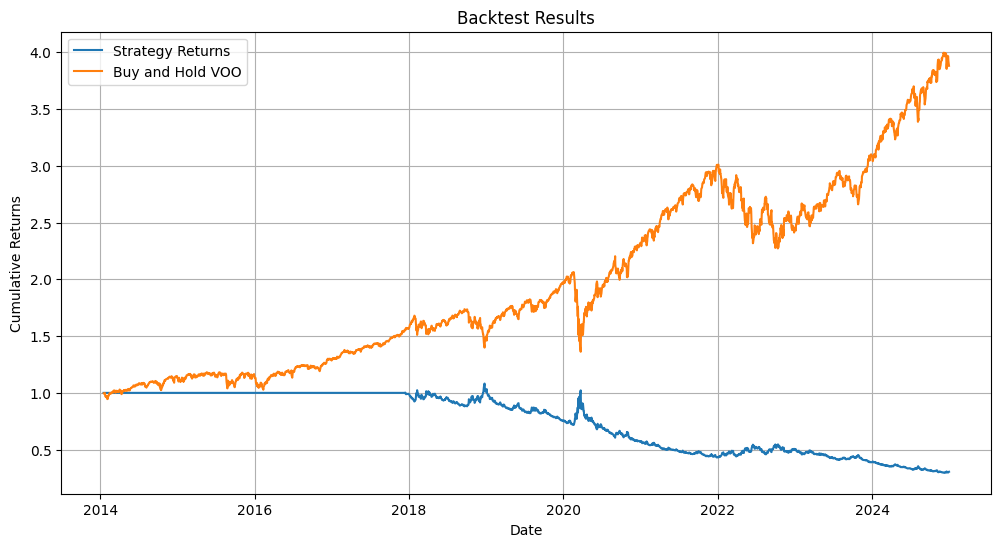

Total Strategy Return: -69.49%
Total Buy and Hold VOO Return: 288.05%
Sharpe Ratio: -0.61
Number of buy: 0
Number of sell: 10


<ipython-input-28-87fe2695a82e>:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-28-87fe2695a82e>:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
backtest_2(df)

In [ ]:
def backtest_1(df,buy_threshold, sell_threshold):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > buy_threshold : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
          trade_count += 1
      elif df.loc[i,'^VIX'] < sell_threshold : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
          trade_count += 1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'].iloc[-1] - 1) * 100

  return {
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': trade_count
  }

In [ ]:
metrics_VIX = []

buy_threshold_range = [10, 20, 30, 40, 50]
sell_threshold_range = [10, 20, 30, 40, 50]
for buy_threshold in buy_threshold_range:
  for sell_threshold in sell_threshold_range:
    metrics_VIX.append(backtest_1(df,buy_threshold, sell_threshold))

summary_VIX_df = pd.DataFrame(metrics_VIX)
summary_VIX_df.index.name = None
summary_VIX_df.to_csv('metrics_VIX.csv')

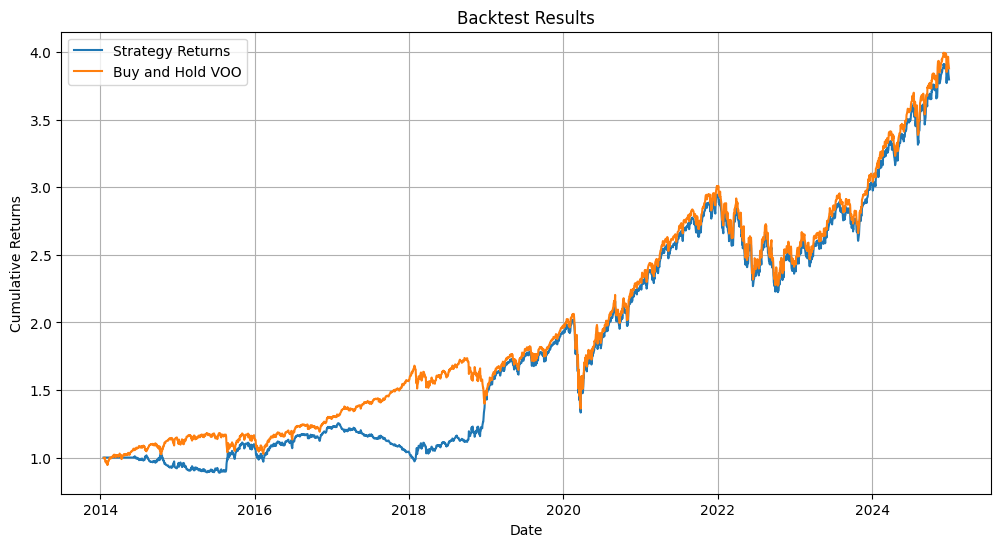

Total Strategy Return: 279.78%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-33-902025a105c4>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-33-902025a105c4>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'^VIX'] > regime_1_vix_mean : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'^VIX'] < regime_0_vix_mean : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")


# Trading Strategy based on VIX RSI

In [ ]:
def backtest_2(df,buy_threshold, sell_threshold, RSI_buy_threshold, RSI_sell_threshold):
  df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

  trade_count = 0

  # Loop through the data to generate signals
  # Use df.index to access rows by their actual index values (dates)
  for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
      if df.loc[i,'^VIX'] > buy_threshold and df.loc[i,'VIX RSI 14'] > RSI_buy_threshold : # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = 1
          trade_count += 1
      elif df.loc[i,'^VIX'] < sell_threshold and df.loc[i,'VIX RSI 14']  < RSI_sell_threshold: # Access the previous row's 'Position' using index location
          df.loc[i,'Position'] = -1
          trade_count += 1
      else:
          df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

  # Calculate daily returns based on the strategy
  df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
  df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

  annualized_vol = df['Strategy_Returns'].std() * np.sqrt(252)
  sharpe = df['Strategy_Returns'].mean() / annualized_vol * np.sqrt(252)

  # Calculate cumulative returns for the strategy and the benchmark
  df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
  df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

  cumulative = df['Cumulative_Strategy_Returns']

  drawdown = (cumulative.cummax() - cumulative).max()

  # Evaluate Performance (example metrics)
  strategy_total_return = (df['Cumulative_Strategy_Returns'].iloc[-1] - 1) * 100

  return {
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'RSI_buy_threshold': RSI_buy_threshold,
        'RSI_sell_threshold': RSI_sell_threshold,
        'Total Return': f"{strategy_total_return:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': trade_count
  }

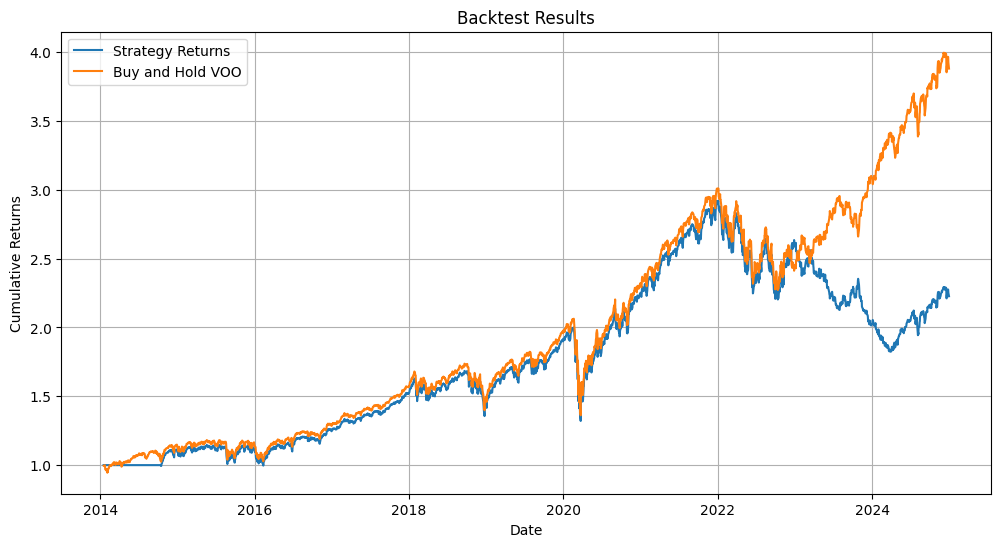

Total Strategy Return: 122.68%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-35-97584b68a9ac>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-35-97584b68a9ac>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
# prompt: Create the strategy to buy VOO when VIX is higher than 30 and sell VOO when VIX is lower than 15. Backtest the strategy

df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)
df['Buy_Signal'] = 0

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX RSI 14']  > 70 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX RSI 14'] < 30 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")


In [ ]:
metrics_VIX_RSI = []

buy_threshold_range = [10, 20, 30, 40, 50]
sell_threshold_range = [10, 20, 30, 40, 50]
RSI_buy_threshold_range = [10, 30, 50, 70]
RSI_sell_threshold_range = [10, 30, 50, 70]
for buy_threshold in buy_threshold_range:
  for sell_threshold in sell_threshold_range:
    for RSI_buy_threshold in RSI_buy_threshold_range:
      for RSI_sell_threshold in RSI_sell_threshold_range:
        metrics_VIX_RSI.append(backtest_2(df, buy_threshold, sell_threshold, RSI_buy_threshold, RSI_sell_threshold))

metrics_VIX_RSI_df = pd.DataFrame(metrics_VIX_RSI)
metrics_VIX_RSI_df.index.name = None
print(metrics_VIX_RSI_df)


     buy_threshold  sell_threshold  RSI_buy_threshold  RSI_sell_threshold  \
0               10              10                 10                  10   
1               10              10                 10                  30   
2               10              10                 10                  50   
3               10              10                 10                  70   
4               10              10                 30                  10   
..             ...             ...                ...                 ...   
395             50              50                 50                  70   
396             50              50                 70                  10   
397             50              50                 70                  30   
398             50              50                 70                  50   
399             50              50                 70                  70   

    Total Return Sharpe Ratio Max Drawdown  Trades  
0        308.66%      

In [27]:
metrics_VIX_RSI_df.to_csv('metrics_VIX_RSI.csv')

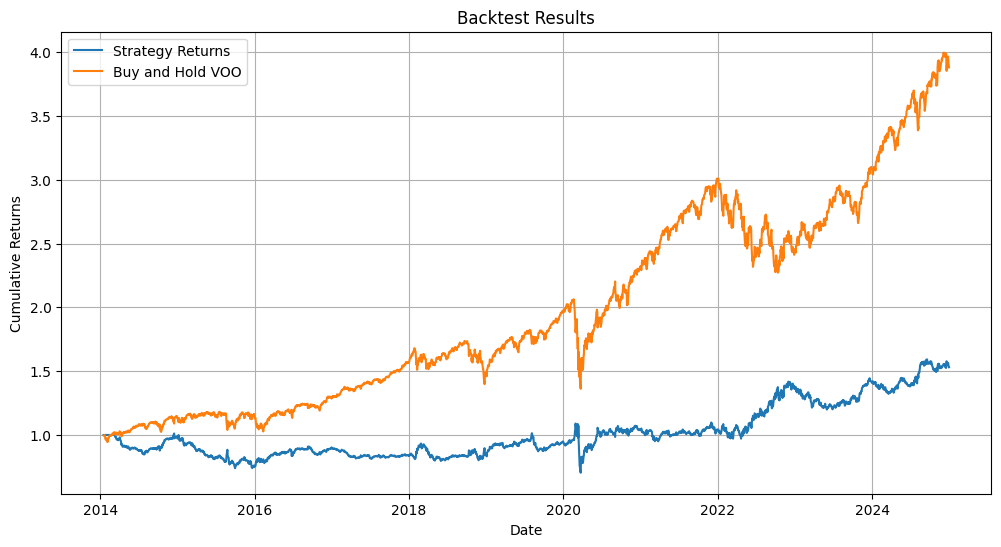

Total Strategy Return: 53.09%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-38-ebc3fcc985b0>:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-38-ebc3fcc985b0>:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
# prompt: Create the strategy to buy VOO when VIX is higher than 30 and sell VOO when VIX is lower than 15. Backtest the strategy

df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)
df['Buy_Signal'] = 0

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX RSI 7 - 35']  < 0 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX RSI 7 - 35'] > 0 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")


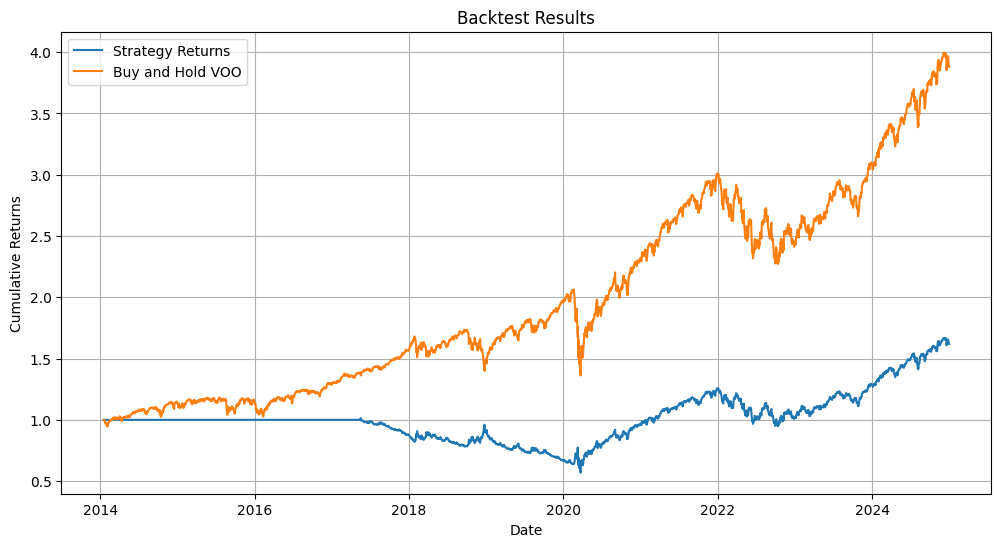

Total Strategy Return: 61.94%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-39-1398bb872952>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-39-1398bb872952>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX lag 1'] > 50  : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX lag 1'] < 10 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

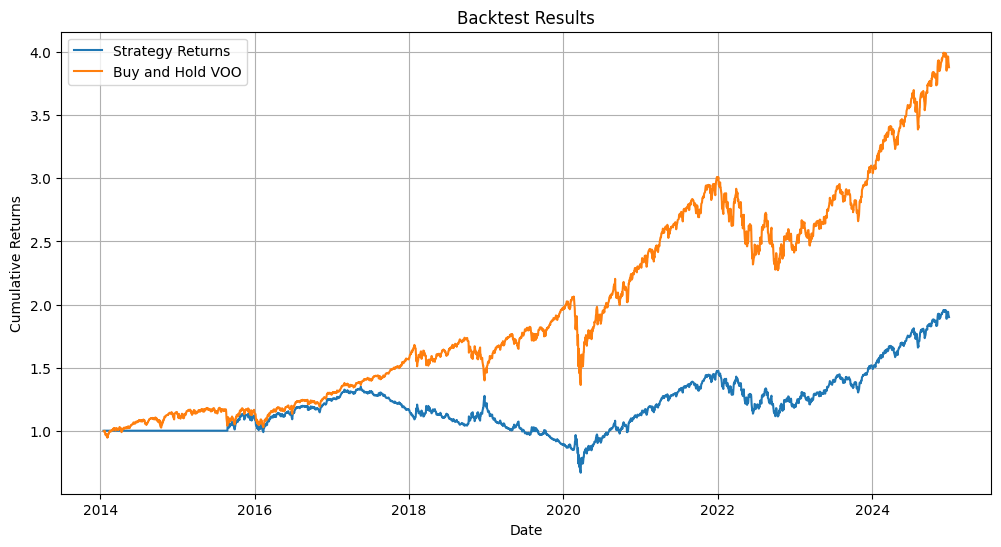

Total Strategy Return: 90.03%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-40-de6b130fc1b0>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-40-de6b130fc1b0>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX lag 1'] > 40 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX lag 1'] < 10 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

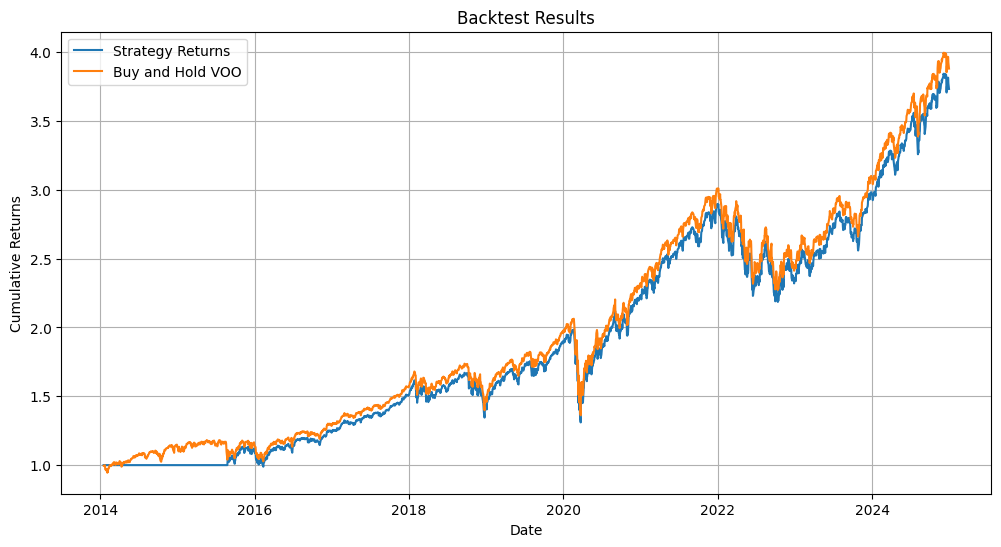

Total Strategy Return: 273.25%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-41-2b98ed846f7f>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-41-2b98ed846f7f>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX lag 1'] > 40 and df.loc[i,'VIX RSI 14'] > 70 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX lag 1'] < 10 and df.loc[i,'VIX RSI 14'] < 30: # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

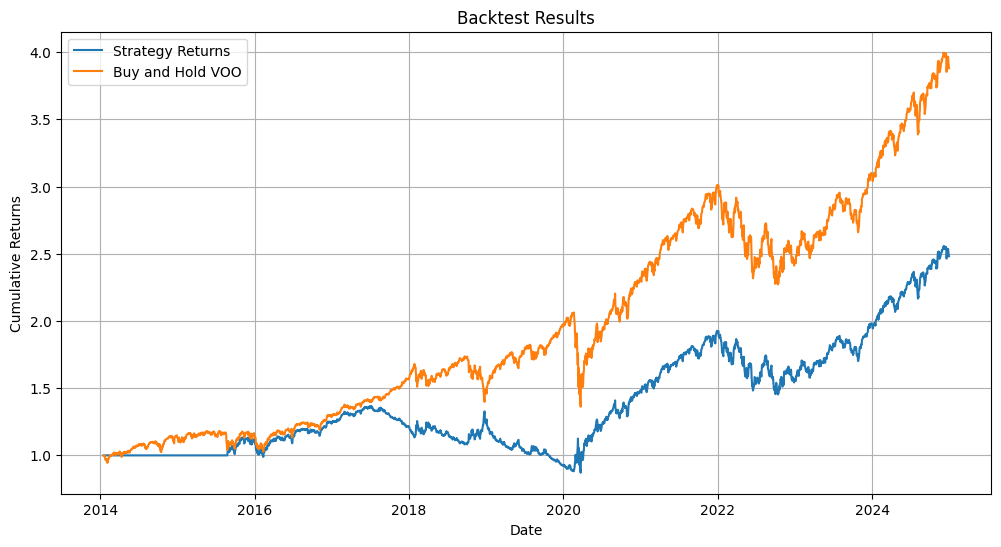

Total Strategy Return: 148.15%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-42-2f8bdb25372e>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-42-2f8bdb25372e>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX lag 1'] > 40 and df.loc[i,'VOO RSI 14'] < 30 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX lag 1'] < 10 and df.loc[i,'VOO RSI 14'] > 70: # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

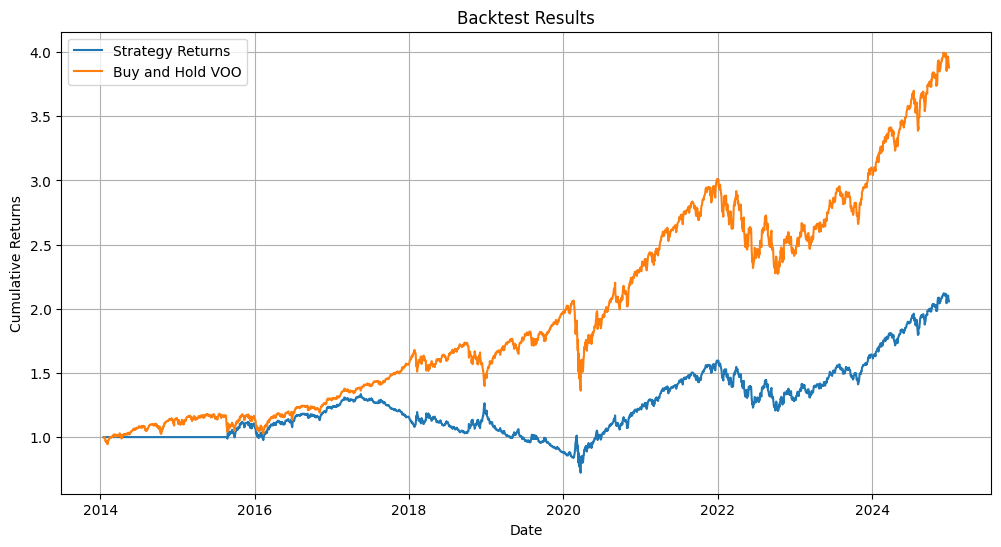

Total Strategy Return: 105.79%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-43-d80762634d8c>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-43-d80762634d8c>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'^VIX'] > 40 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'^VIX'] < 10: # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

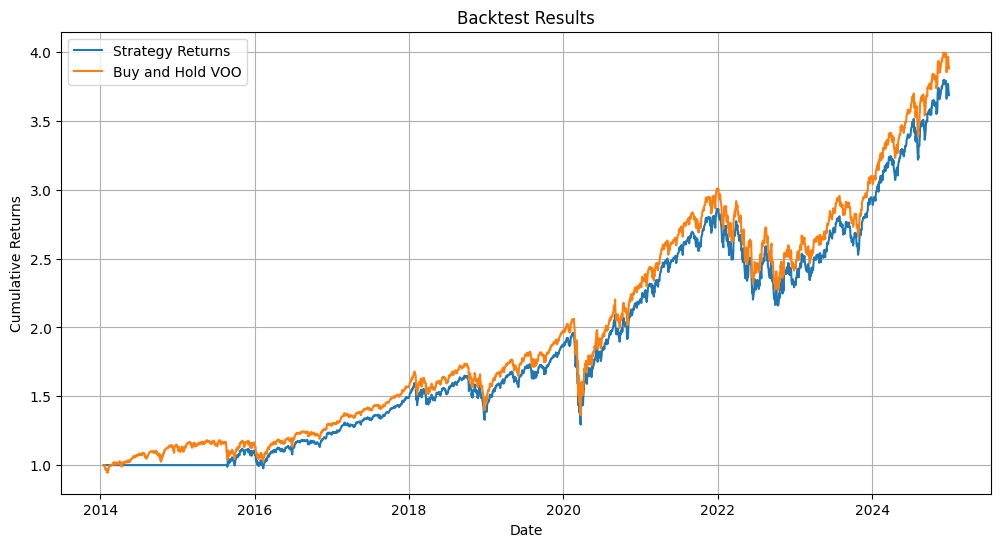

Total Strategy Return: 268.71%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-44-8c69ab1a9ba8>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-44-8c69ab1a9ba8>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'^VIX'] > 40 and df.loc[i,'VIX RSI 14'] > 70 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'^VIX'] < 10 and df.loc[i,'VIX RSI 14'] < 30: # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

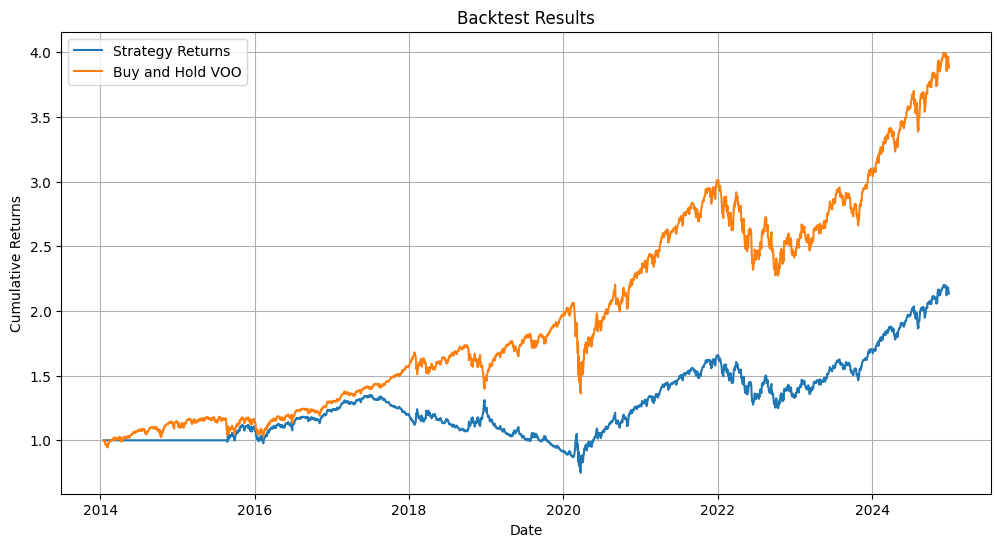

Total Strategy Return: 113.51%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-45-840841f4ec1c>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-45-840841f4ec1c>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'^VIX'] > 40 and df.loc[i,'VOO RSI 14'] < 30 : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'^VIX'] < 10 and df.loc[i,'VOO RSI 14'] > 70: # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

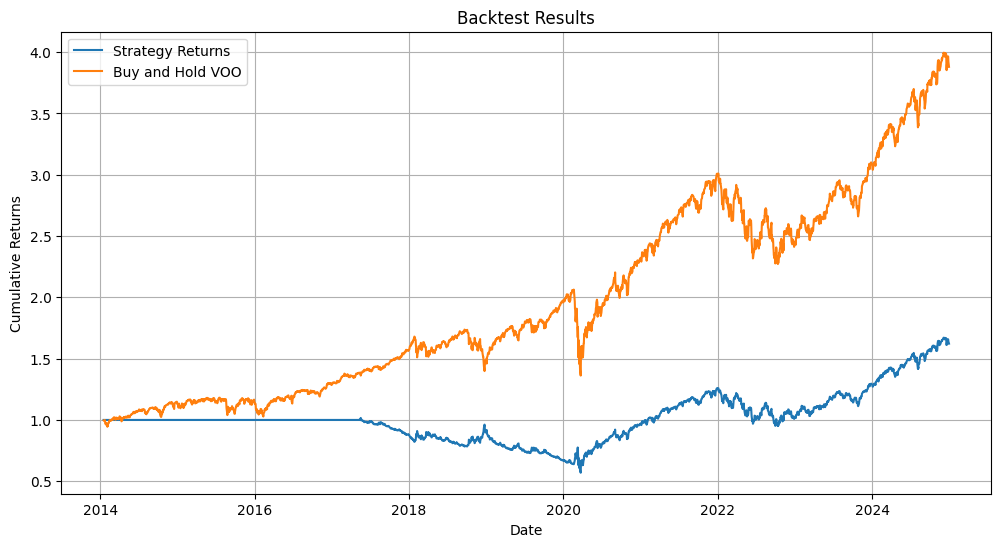

Total Strategy Return: 62.24%
Total Buy and Hold VOO Return: 288.05%


<ipython-input-46-7211ef77ac74>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
<ipython-input-46-7211ef77ac74>:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100


In [ ]:
df['Position'] = 0  # Initialize a column to track positions (0: no position, 1: long)

# Loop through the data to generate signals
# Use df.index to access rows by their actual index values (dates)
for i in df.index[1:]:  # Start from the second row to avoid issues with previous values
    if df.loc[i,'VIX lag 1'] > 40 and df.loc[i,'GARCH predict'] > df.loc[i,'GARCH predict shift 1'] : # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = 1
    elif df.loc[i,'VIX lag 1'] < 10 and df.loc[i,'GARCH predict'] < df.loc[i,'GARCH predict shift 1']: # Access the previous row's 'Position' using index location
        df.loc[i,'Position'] = -1
    else:
        df.loc[i,'Position'] = df.loc[df.index[df.index.get_loc(i) - 1],'Position'] # Access the previous row's 'Position' using index location

# Calculate daily returns based on the strategy
df['Strategy_Returns'] = df['VOO'].pct_change() * df['Position'].shift(1) #shift because we enter a position at the end of the day
df['Strategy_Returns'] = df['Strategy_Returns'].fillna(0) #first day will be Nan

# Calculate cumulative returns for the strategy and the benchmark
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_VOO_Returns'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return = (df['Cumulative_Strategy_Returns'][-1] - 1) * 100
buy_and_hold_total_return = (df['Cumulative_VOO_Returns'][-1]-1) * 100
print(f"Total Strategy Return: {strategy_total_return:.2f}%")
print(f"Total Buy and Hold VOO Return: {buy_and_hold_total_return:.2f}%")

#Further analysis can include metrics like Sharpe ratio, Maximum Drawdown etc.

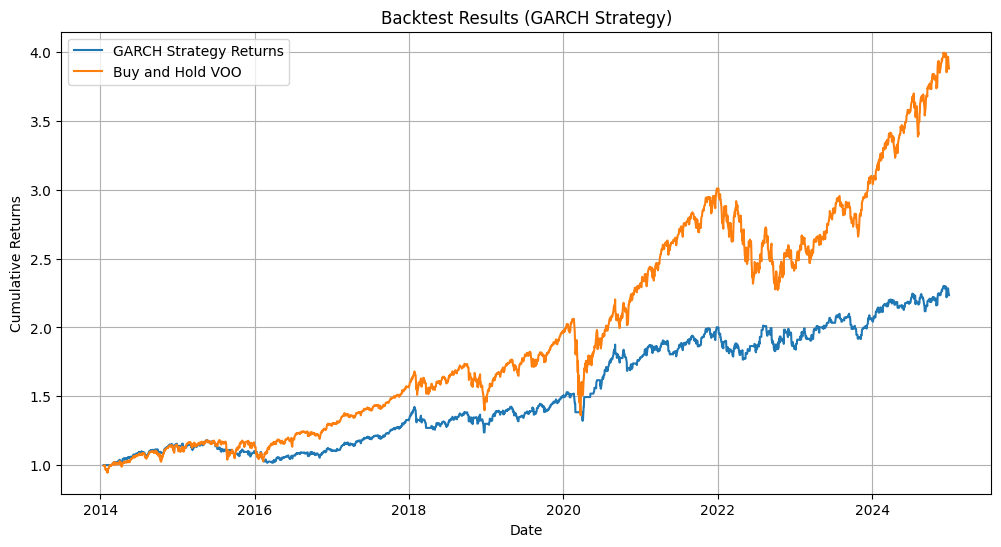

📉 GARCH Strategy Performance:
Total Return: 123.44%
Sharpe Ratio: 0.71
Number of Trades: 350


In [ ]:
df['GARCH Signal'] = np.where(df['GARCH predict shift 1'] > df['VOO pct change sd'], 1, 0)
# Apply GARCH signal as strategy position
df['Position_GARCH'] = df['GARCH Signal']

# Calculate strategy returns
df['Strategy_Returns_GARCH'] = df['VOO'].pct_change() * df['Position_GARCH'].shift(1)
df['Strategy_Returns_GARCH'] = df['Strategy_Returns_GARCH'].fillna(0)

# Cumulative returns
df['Cumulative_Strategy_Returns_GARCH'] = (1 + df['Strategy_Returns_GARCH']).cumprod()
df['Cumulative_VOO_Returns_GARCH'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns_GARCH'], label='GARCH Strategy Returns')
plt.plot(df.index, df['Cumulative_VOO_Returns_GARCH'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results (GARCH Strategy)')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
sharpe_garch = df['Strategy_Returns_GARCH'].mean() / df['Strategy_Returns_GARCH'].std() * np.sqrt(252)
total_return_garch = (df['Cumulative_Strategy_Returns_GARCH'].iloc[-1] - 1) * 100
num_trades_garch = df['Position_GARCH'].diff().abs().sum() / 2

print(f"📉 GARCH Strategy Performance:")
print(f"Total Return: {total_return_garch:.2f}%")
print(f"Sharpe Ratio: {sharpe_garch:.2f}")
print(f"Number of Trades: {int(num_trades_garch)}")


# LSTM model building and Backtesting

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0023

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 2/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2433e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0941e-04 - val_loss: 0.0015
Epoch 3/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.5036e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2056e-04 - val_loss: 0.0013
Epoch 4/100
26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7224e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7685e-04 - val_loss: 0.0013
Epoch 5/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1060e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0050e-04 - val_loss: 0.0011
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.6067e-04 - val_loss: 0.0011
Epoch 7/100
23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9836e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0120e-04 - val_loss: 0.0010
Epoch 8/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1705e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3552e-04 - val_loss: 9.9774e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1567e-04 - val_loss: 0.0011
Epoch 10/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9101e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8649e-04 - val_loss: 9.0469e-04
Epoch 11/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0651e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.0842e-04 - val_loss: 8.2269e-04
Epoch 12/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2002e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2158e-04 - val_loss: 8.1428e-04
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6345e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.6474e-04 - val_loss: 8.0058e-04
Epoch 14/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5709e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.6011e-04 - val_loss: 7.7471e-04
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0468e-04 - val_loss: 9.1541e-04
Epoch 16/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4923e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5560e-04 - val_loss: 7.4391e-04
Epoch 17/100
27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7703e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7567e-04 - val_loss: 7.2775e-04
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9990e-04 - val_loss: 8.6277e-04
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6706e-04 - val_loss: 7.6191e-04
Epoch 20/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8268e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8204e-04 - val_loss: 7.1734e-04
Epoch 21/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5683e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5596e-04 - val_loss: 6.7435e-04
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2193e-04 - val_loss: 6.8227e-04
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4644e-04 - val_loss: 6.9266e-04
Epoch 24/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2606e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3019e-04 - val_loss: 6.6468e-04
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0709e-04 - val_loss: 7.0613e-04
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7089e-04 - val_loss: 6.8684e-04
Epoch 27/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5806e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5177e-04 - val_loss: 6.6119e-04
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8757e-04 - val_loss: 6.6437e-04
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5417e-04 - val_loss: 6.7841e-04
Epoch 30/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2599e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2539e-04 - val_loss: 6.4722e-04
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1644e-04 - val_loss: 6.8681e-04
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2198e-04 - val_loss: 6.7987e-04
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2686e-04 - val_loss: 6.7288e-04
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2038e-04 - val_loss: 6.6618e-04
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0038e-04 - val_loss: 6.6517e-04
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8979e-04 - val_loss: 7.4043e-04
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5164e-04 - val_loss: 6.5742e-04
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7477e-04 - val_loss: 6.6039e-04
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7333e-04 - val_loss: 6.4725e-04
Epoch 40/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8231e

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8368e-04 - val_loss: 6.4287e-04
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7579e-04 - val_loss: 6.9001e-04
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8925e-04 - val_loss: 6.4379e-04
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6115e-04 - val_loss: 6.4355e-04
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8528e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8537e-04 - val_loss: 6.3067e-04
Epoch 45/100
25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1982e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1910e-04 - val_loss: 6.2285e-04
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8263e-04 - val_loss: 6.2756e-04
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7669e-04 - val_loss: 6.4229e-04
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0906e-04 - val_loss: 6.6482e-04
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7732e-04 - val_loss: 6.3141e-04
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6847e-04 - val_loss: 6.3182e-04
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7498e-04 - val_loss: 6.4614e-04
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7955e-04 - val_loss: 6.3527e-04
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9736e-04 - val_loss: 6.3624e-04
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0397e-04 - val_loss: 6.2384e-04
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5996e-04

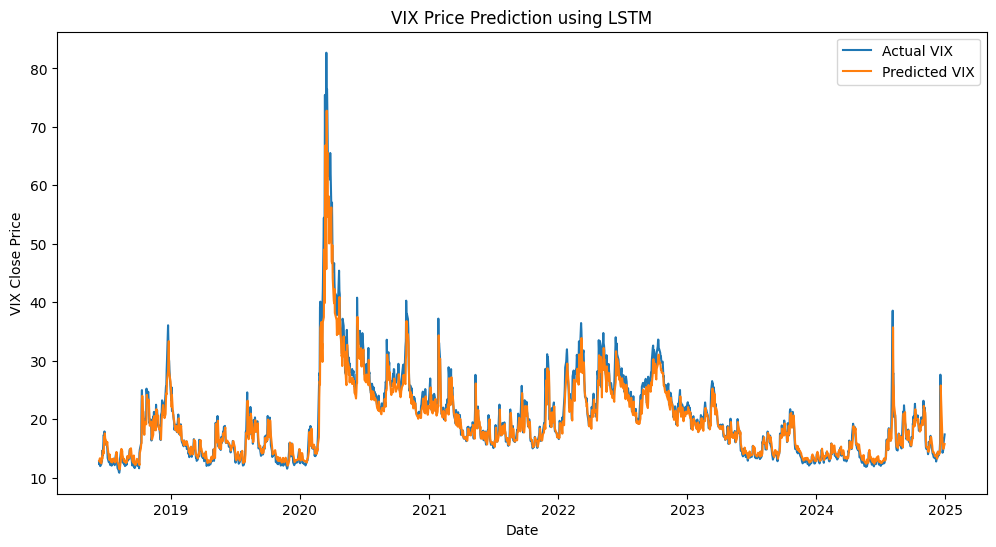

In [35]:
# prompt: build a LSTM model for the prediction of column ^VIX with the variable with lag 5

# Prepare the data for LSTM
# We want to predict '^VIX' based on its past values with lag 5.
# Create lagged features
lag = 5
df_lstm = df[['^VIX']].copy()
for i in range(1, lag + 1):
  df_lstm[f'VIX_lag_{i}'] = df_lstm['^VIX'].shift(i)

df_lstm = df_lstm.dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Create sequences for LSTM
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:(i + seq_length), :])
    y.append(data[i + seq_length, 0]) # Predict the current ^VIX value (first column)
  return np.array(X), np.array(y)

seq_length = lag # Use the lag as the sequence length
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.4)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM input [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=25))
model.add(tf.keras.layers.Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

# Train the model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint]
)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index[len(X_train) + lag:], y_test_actual, label='Actual VIX')
plt.plot(df_lstm.index[len(X_train) + lag:], predictions, label='Predicted VIX')
plt.title('VIX Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('VIX Close Price')
plt.legend()
plt.show()

<ipython-input-36-fb71c9e08341>:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_strategy['Cumulative_VOO_Returns'] = (1 + df_strategy['VOO'].pct_change()).cumprod().reindex(df_strategy.index).fillna(method='ffill')


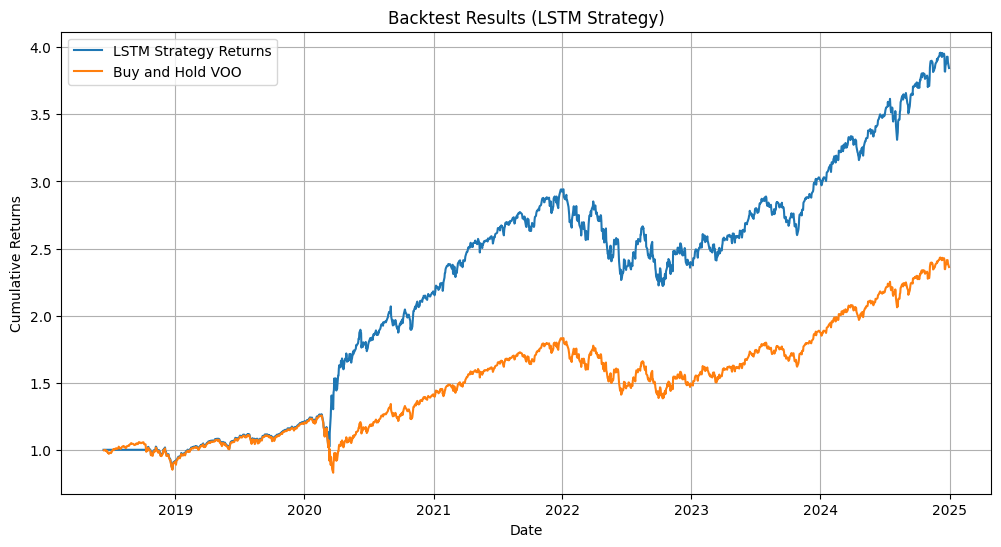

Total LSTM Strategy Return: 284.52%
Total Buy and Hold VOO Return (during LSTM prediction period): 136.21%
LSTM Strategy Sharpe Ratio: 1.14


<ipython-input-36-fb71c9e08341>:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strategy_total_return_lstm = (df_strategy['Cumulative_Strategy_Returns_LSTM'][-1] - 1) * 100
<ipython-input-36-fb71c9e08341>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_and_hold_total_return_lstm = (df_strategy['Cumulative_VOO_Returns'][-1]-1) * 100


In [36]:
# prompt: Write a code to formulate the strategy by using the prediction from LSTM and generate the buying signal if the prediction is more than 30

# Formulate the strategy based on LSTM prediction
# Add the LSTM predictions to the original dataframe. Need to align by date.
# The predictions correspond to the dates in df_lstm.index[len(X_train) + lag:]
# We need to create a mapping for the dates.

prediction_start = len(X_train) + lag

# Create a Series with proper indexing from df_lstm
lstm_predictions_series = pd.Series(
    predictions,
    index=df_lstm.index[prediction_start:],
    name='LSTM_Prediction'
)

# Add a column for LSTM predictions, initialized with NaNs
df['LSTM_Prediction'] = np.nan

# Insert predictions directly by index alignment (safer than update)
df.loc[lstm_predictions_series.index, 'LSTM_Prediction'] = lstm_predictions_series

# Optionally shift predictions if using for forward-looking signal generation
df['LSTM_Prediction_Shifted'] = df['LSTM_Prediction'].shift(-1)

# Drop rows with no prediction (typically the early rows)
df_strategy = df.dropna(subset=['LSTM_Prediction']).copy()

# Implement a simple strategy: go long when buy signal is 1, stay in position
df_strategy['Position_LSTM'] = 0
for i in range(1, len(df_strategy)):
  if df_strategy['LSTM_Prediction'].iloc[i] > df_strategy['LSTM_Prediction'].iloc[i-1]+10:
    df_strategy.at[df_strategy.index[i], 'Position_LSTM'] = -1
  elif df_strategy['LSTM_Prediction'].iloc[i] < df_strategy['LSTM_Prediction'].iloc[i-1]-2:
    df_strategy.at[df_strategy.index[i], 'Position_LSTM'] = 1
  else:
    df_strategy.iloc[i, df_strategy.columns.get_loc('Position_LSTM')] = df_strategy.iloc[i-1, df_strategy.columns.get_loc('Position_LSTM')]

# Calculate daily returns based on the LSTM strategy
df_strategy['Strategy_Returns_LSTM'] = df_strategy['VOO'].pct_change() * df_strategy['Position_LSTM'].shift(1)
df_strategy['Strategy_Returns_LSTM'] = df_strategy['Strategy_Returns_LSTM'].fillna(0)

# Calculate cumulative returns for the LSTM strategy and the benchmark
df_strategy['Cumulative_Strategy_Returns_LSTM'] = (1 + df_strategy['Strategy_Returns_LSTM']).cumprod()
df_strategy['Cumulative_VOO_Returns'] = (1 + df_strategy['VOO'].pct_change()).cumprod().reindex(df_strategy.index).fillna(method='ffill')


# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df_strategy.index, df_strategy['Cumulative_Strategy_Returns_LSTM'], label='LSTM Strategy Returns')
plt.plot(df_strategy.index, df_strategy['Cumulative_VOO_Returns'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results (LSTM Strategy)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Performance (example metrics)
strategy_total_return_lstm = (df_strategy['Cumulative_Strategy_Returns_LSTM'][-1] - 1) * 100
buy_and_hold_total_return_lstm = (df_strategy['Cumulative_VOO_Returns'][-1]-1) * 100

print(f"Total LSTM Strategy Return: {strategy_total_return_lstm:.2f}%")
print(f"Total Buy and Hold VOO Return (during LSTM prediction period): {buy_and_hold_total_return_lstm:.2f}%")

# Calculate Sharpe Ratio for the LSTM strategy
strategy_sharpe_ratio_lstm = df_strategy['Strategy_Returns_LSTM'].mean() / df_strategy['Strategy_Returns_LSTM'].std() * np.sqrt(252)
print(f"LSTM Strategy Sharpe Ratio: {strategy_sharpe_ratio_lstm:.2f}")

# Count number of buy signals
# num_lstm_buy_signals = df_strategy['LSTM_Signal'].sum()
# print(f"Number of LSTM Buy Signals: {num_lstm_buy_signals}")


In [30]:
# === LSTM Performance Summary ===
strategy_total_return_lstm = (df_strategy['Cumulative_Strategy_Returns_LSTM'].iloc[-1] - 1) * 100
buy_and_hold_total_return_lstm = (df_strategy['Cumulative_VOO_Returns'].iloc[-1] - 1) * 100
sharpe_lstm = df_strategy['Strategy_Returns_LSTM'].mean() / df_strategy['Strategy_Returns_LSTM'].std() * np.sqrt(252)
num_trades_lstm = df_strategy['Position_LSTM'].diff().abs().sum() / 2  # counts entries/exits

print(f"📈 LSTM Strategy Performance:")
print(f"Total Return: {strategy_total_return_lstm:.2f}%")
print(f"Buy & Hold Return: {buy_and_hold_total_return_lstm:.2f}%")
print(f"Sharpe Ratio: {sharpe_lstm:.2f}")
print(f"Number of Trades: {int(num_trades_lstm)}")


📈 LSTM Strategy Performance:
Total Return: 233.46%
Buy & Hold Return: 136.21%
Sharpe Ratio: 1.03
Number of Trades: 6


In [37]:
# Define signal: LSTM forecast implies trend, GARCH implies volatility rising
df['LSTM_GARCH_Signal'] = 0
for i in range(1, len(df)):
    if (
        pd.notna(df['LSTM_Prediction'].iloc[i])
        and pd.notna(df['GARCH predict'].iloc[i])
        and pd.notna(df['GARCH predict shift 1'].iloc[i])
    ):
        if (
            df['LSTM_Prediction'].iloc[i] < df['LSTM_Prediction'].iloc[i-1] - 2 and
            df['GARCH predict'].iloc[i] > df['GARCH predict shift 1'].iloc[i]
        ):
            df.at[df.index[i], 'LSTM_GARCH_Signal'] = 1  # Buy
        elif (
            df['LSTM_Prediction'].iloc[i] > df['LSTM_Prediction'].iloc[i-1] + 2 and
            df['GARCH predict'].iloc[i] > df['GARCH predict shift 1'].iloc[i]
        ):
            df.at[df.index[i], 'LSTM_GARCH_Signal'] = -1  # Sell
        else:
            df.at[df.index[i], 'LSTM_GARCH_Signal'] = df.at[df.index[i-1], 'LSTM_GARCH_Signal']
    else:
        df.at[df.index[i], 'LSTM_GARCH_Signal'] = df.at[df.index[i-1], 'LSTM_GARCH_Signal']


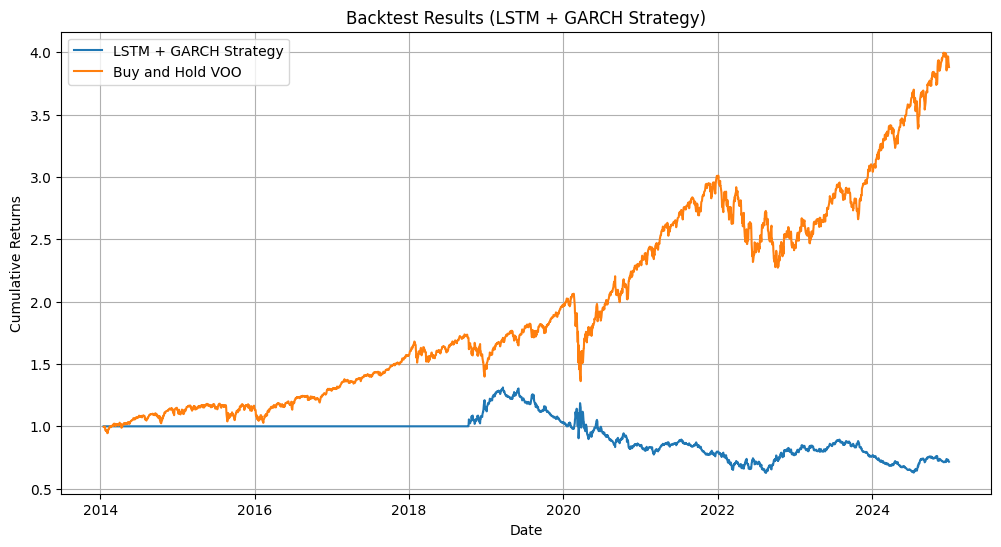

LSTM + GARCH Strategy Performance:
Total Return: -28.39%
Sharpe Ratio: -0.12
Number of Trades: 67


In [38]:
# Calculate hybrid strategy returns
df['Strategy_Returns_LSTM_GARCH'] = df['VOO'].pct_change() * df['LSTM_GARCH_Signal'].shift(1)
df['Strategy_Returns_LSTM_GARCH'] = df['Strategy_Returns_LSTM_GARCH'].fillna(0)
df['Cumulative_Strategy_Returns_LSTM_GARCH'] = (1 + df['Strategy_Returns_LSTM_GARCH']).cumprod()
df['Cumulative_VOO_Returns_LSTM_GARCH'] = (1 + df['VOO'].pct_change()).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative_Strategy_Returns_LSTM_GARCH'], label='LSTM + GARCH Strategy')
plt.plot(df.index, df['Cumulative_VOO_Returns_LSTM_GARCH'], label='Buy and Hold VOO')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Results (LSTM + GARCH Strategy)')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
sharpe_lstm_garch = df['Strategy_Returns_LSTM_GARCH'].mean() / df['Strategy_Returns_LSTM_GARCH'].std() * np.sqrt(252)
total_return_lstm_garch = (df['Cumulative_Strategy_Returns_LSTM_GARCH'].iloc[-1] - 1) * 100
num_trades_lstm_garch = df['LSTM_GARCH_Signal'].diff().abs().sum() / 2

print(f"LSTM + GARCH Strategy Performance:")
print(f"Total Return: {total_return_lstm_garch:.2f}%")
print(f"Sharpe Ratio: {sharpe_lstm_garch:.2f}")
print(f"Number of Trades: {int(num_trades_lstm_garch)}")


**Enhancements**

In [39]:
# Recreate LSTM-based signal: long when prediction is dropping significantly, short when rising
df['Position_LSTM'] = 0

for i in range(1, len(df)):
    if (
        pd.notna(df['LSTM_Prediction'].iloc[i])
        and pd.notna(df['LSTM_Prediction'].iloc[i - 1])
    ):
        if df['LSTM_Prediction'].iloc[i] < df['LSTM_Prediction'].iloc[i - 1] - 2:
            df.iloc[i, df.columns.get_loc('Position_LSTM')] = 1  # Long VOO
        elif df['LSTM_Prediction'].iloc[i] > df['LSTM_Prediction'].iloc[i - 1] + 10:
            df.iloc[i, df.columns.get_loc('Position_LSTM')] = -1  # Short VOO
        else:
            df.iloc[i, df.columns.get_loc('Position_LSTM')] = df.iloc[i - 1, df.columns.get_loc('Position_LSTM')]
    else:
        df.iloc[i, df.columns.get_loc('Position_LSTM')] = df.iloc[i - 1, df.columns.get_loc('Position_LSTM')]

# Assumes GARCH forecast and realized std dev already exist
df['GARCH Signal'] = np.where(df['GARCH predict shift 1'] > df['VOO pct change sd'], 1, 0)
df['Position_GARCH'] = df['GARCH Signal']

# Split data by regime
regime_0 = df[df['Regime'] == 0]
regime_1 = df[df['Regime'] == 1]

# LSTM in Regime 0
lstm_return_0 = (regime_0['VOO'].pct_change() * regime_0['Position_LSTM'].shift(1)).dropna()
sharpe_lstm_0 = lstm_return_0.mean() / lstm_return_0.std() * np.sqrt(252)
total_lstm_0 = (1 + lstm_return_0).prod() - 1

# GARCH in Regime 0
garch_return_0 = (regime_0['VOO'].pct_change() * regime_0['Position_GARCH'].shift(1)).dropna()
sharpe_garch_0 = garch_return_0.mean() / garch_return_0.std() * np.sqrt(252)
total_garch_0 = (1 + garch_return_0).prod() - 1

# LSTM in Regime 1
lstm_return_1 = (regime_1['VOO'].pct_change() * regime_1['Position_LSTM'].shift(1)).dropna()
sharpe_lstm_1 = lstm_return_1.mean() / lstm_return_1.std() * np.sqrt(252)
total_lstm_1 = (1 + lstm_return_1).prod() - 1

# GARCH in Regime 1
garch_return_1 = (regime_1['VOO'].pct_change() * regime_1['Position_GARCH'].shift(1)).dropna()
sharpe_garch_1 = garch_return_1.mean() / garch_return_1.std() * np.sqrt(252)
total_garch_1 = (1 + garch_return_1).prod() - 1

# Print results
print("Performance by Regime:\n")
print("Regime 0 (calm):")
print(f"  LSTM -> Sharpe: {sharpe_lstm_0:.2f}, Total Return: {total_lstm_0*100:.2f}%")
print(f"  GARCH -> Sharpe: {sharpe_garch_0:.2f}, Total Return: {total_garch_0*100:.2f}%\n")

print("Regime 1 (volatile):")
print(f"  LSTM -> Sharpe: {sharpe_lstm_1:.2f}, Total Return: {total_lstm_1*100:.2f}%")
print(f"  GARCH -> Sharpe: {sharpe_garch_1:.2f}, Total Return: {total_garch_1*100:.2f}%")


Performance by Regime:

Regime 0 (calm):
  LSTM -> Sharpe: 1.22, Total Return: 286.16%
  GARCH -> Sharpe: 0.47, Total Return: 33.28%

Regime 1 (volatile):
  LSTM -> Sharpe: 1.10, Total Return: 140.61%
  GARCH -> Sharpe: 1.13, Total Return: 165.54%


In [41]:
df['VOO_pct'] = df['VOO'].pct_change()
df['GARCH_pred'] = df['GARCH predict'].shift(1)
df['RSI_14'] = df['VIX RSI 14']
df['VIX_5d_avg'] = df['^VIX'].rolling(5).mean()
df['VIX_change'] = df['^VIX'].pct_change()
df['VOO_gap'] = df['VOO_pct'].shift(-1) - df['VOO_pct']
df['log_VIX'] = np.log(df['^VIX'])

# Define final features
features = ['VOO_pct', 'GARCH_pred', 'RSI_14',
            'VIX_5d_avg', 'VIX_change', 'VOO_gap']

# Target variations
df = df.dropna().copy()
scalers = {col: MinMaxScaler() for col in features}
for col in features:
    df[col] = scalers[col].fit_transform(df[[col]])
lag = 5
for col in features:
    for i in range(1, lag + 1):
        df[f'{col}_lag_{i}'] = df[col].shift(i)

df_lstm_all = df.dropna().copy()
def create_sequences(data, feature_cols, target_col, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[feature_cols].iloc[i:i+seq_len].values)
        y.append(data[target_col].iloc[i+seq_len])
    return np.array(X), np.array(y)

feature_cols = [f'{col}_lag_{i}' for col in features for i in range(1, lag + 1)]
# Model A: Predict raw VIX
X_a, y_a = create_sequences(df_lstm_all, feature_cols, '^VIX', lag)

# Model B: Predict log(VIX)
X_b, y_b = create_sequences(df_lstm_all, feature_cols, 'log_VIX', lag)

# Model C: Predict log(VIX) with deeper + bidirectional model
X_c, y_c = X_b.copy(), y_b.copy()  # same inputs/target as Model B

train_size = int(len(X_a) * 0.4)
X_train_a, X_test_a = X_a[:train_size], X_a[train_size:]
y_train_a, y_test_a = y_a[:train_size], y_a[train_size:]

X_train_b, X_test_b = X_b[:train_size], X_b[train_size:]
y_train_b, y_test_b = y_b[:train_size], y_b[train_size:]

X_train_c, X_test_c = X_c[:train_size], X_c[train_size:]
y_train_c, y_test_c = y_c[:train_size], y_c[train_size:]


In [42]:
model_a = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_a.shape[1], X_train_a.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_a.compile(optimizer='adam', loss='huber')
model_a.fit(X_train_a, y_train_a, epochs=100, batch_size=32, validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
y_pred_a = model_a.predict(X_test_a).flatten()


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 19.8705 - val_loss: 20.4949
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 14.0167 - val_loss: 9.4437
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2626 - val_loss: 5.9186
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6877 - val_loss: 6.7191
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3256 - val_loss: 7.4552
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4122 - val_loss: 7.2043
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0131 - val_loss: 7.4991
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6845 - val_loss: 6.9341
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1155 - val_loss: 7.3717
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6717 - val_loss: 7.3128
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6572 - val_loss: 7.4625
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 

In [43]:
model_b = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_b.shape[1], X_train_b.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model_b.compile(optimizer='adam', loss='huber')
model_b.fit(X_train_b, y_train_b, epochs=100, batch_size=32, validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
y_pred_b = np.exp(model_b.predict(X_test_b).flatten())


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.8543 - val_loss: 0.1777
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1982 - val_loss: 0.0142
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0840 - val_loss: 0.0239
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0593 - val_loss: 0.0286
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0453 - val_loss: 0.0246
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0468 - val_loss: 0.0224
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0443 - val_loss: 0.0375
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0426 - val_loss: 0.0208
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0409 - val_loss: 0.0419
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0484 - val_loss: 0.0173
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0465 - val_loss: 0.0179
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

In [44]:
model_c = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_c.shape[1], X_train_c.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])
model_c.compile(optimizer='adam', loss='huber')
model_c.fit(X_train_c, y_train_c, epochs=100, batch_size=32, validation_split=0.1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
y_pred_c = np.exp(model_c.predict(X_test_c).flatten())


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 2.0452 - val_loss: 0.0463
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1474 - val_loss: 0.1476
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1042 - val_loss: 0.0248
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0861 - val_loss: 0.0401
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0836 - val_loss: 0.0523
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0747 - val_loss: 0.0382
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0729 - val_loss: 0.0318
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0591 - val_loss: 0.0239
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0302 - val_loss: 0.0302
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0276 - val_loss: 0.0176
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0239 - val_loss: 0.0207
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0

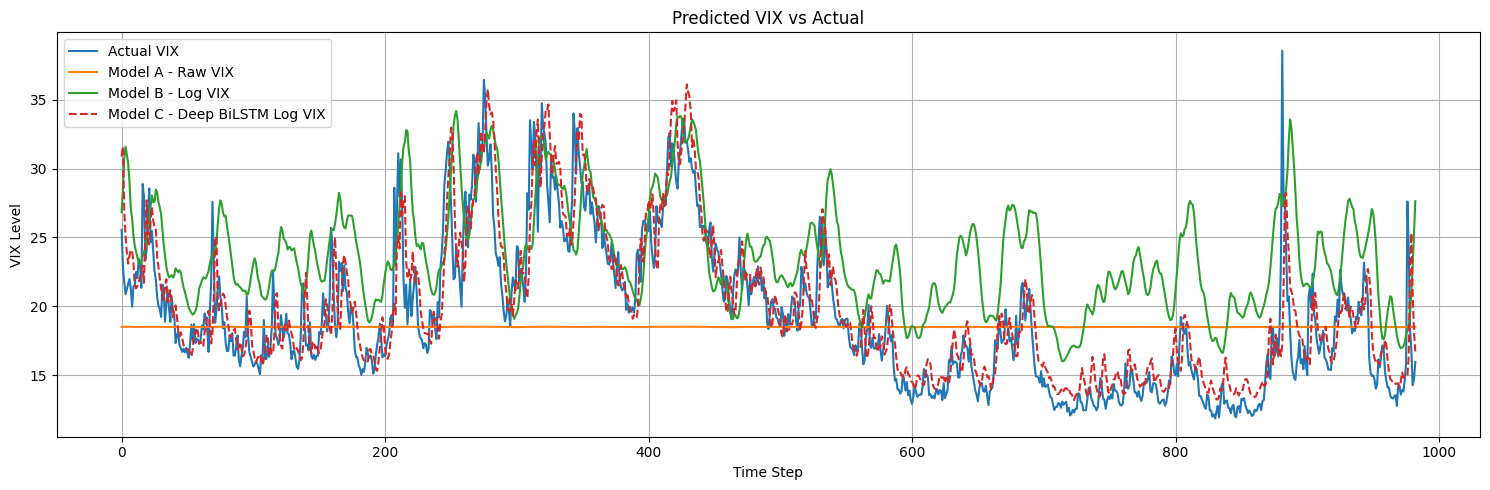

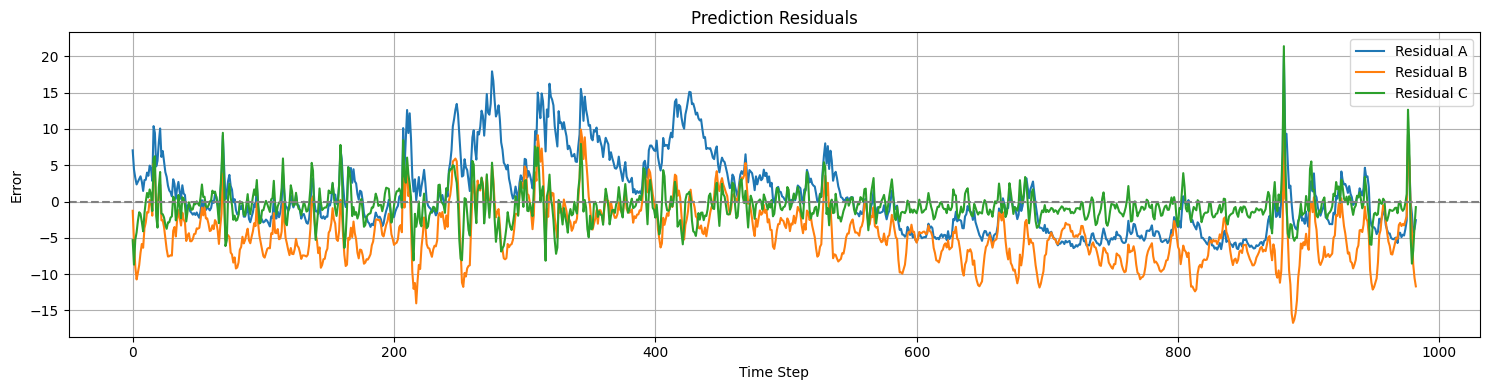


📈 Model A - Raw VIX
Mean Squared Error : 28.0562
Mean Absolute Error: 4.1149

📈 Model B - Log VIX
Mean Squared Error : 33.4941
Mean Absolute Error: 4.9644

📈 Model C - Deep BiLSTM Log VIX
Mean Squared Error : 5.9936
Mean Absolute Error: 1.7648


In [46]:
# --- Step 1: Actual Series (same for all)
actual_vix = y_test_a  # raw VIX (used in all 3)

# --- Step 2: Error Metrics Function ---
def print_error_metrics(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n📈 {label}")
    print(f"Mean Squared Error : {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    return mse, mae

# --- Step 3: Plot Actual vs Predicted ---
plt.figure(figsize=(15, 5))
plt.plot(actual_vix, label='Actual VIX', linewidth=1.5)
plt.plot(y_pred_a, label='Model A - Raw VIX')
plt.plot(y_pred_b, label='Model B - Log VIX')
plt.plot(y_pred_c, label='Model C - Deep BiLSTM Log VIX', linestyle='--')
plt.title("Predicted VIX vs Actual")
plt.xlabel("Time Step")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 4: Plot Residuals ---
plt.figure(figsize=(15, 4))
plt.plot(actual_vix - y_pred_a, label='Residual A')
plt.plot(actual_vix - y_pred_b, label='Residual B')
plt.plot(actual_vix - y_pred_c, label='Residual C')
plt.title("Prediction Residuals")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Step 5: Print Metrics ---
metrics_a = print_error_metrics(actual_vix, y_pred_a, "Model A - Raw VIX")
metrics_b = print_error_metrics(actual_vix, y_pred_b, "Model B - Log VIX")
metrics_c = print_error_metrics(actual_vix, y_pred_c, "Model C - Deep BiLSTM Log VIX")


Signal distribution:
  0    588
-1    197
 1    197
Name: count, dtype: int64
Cumulative return end value: 0.6946066402875786


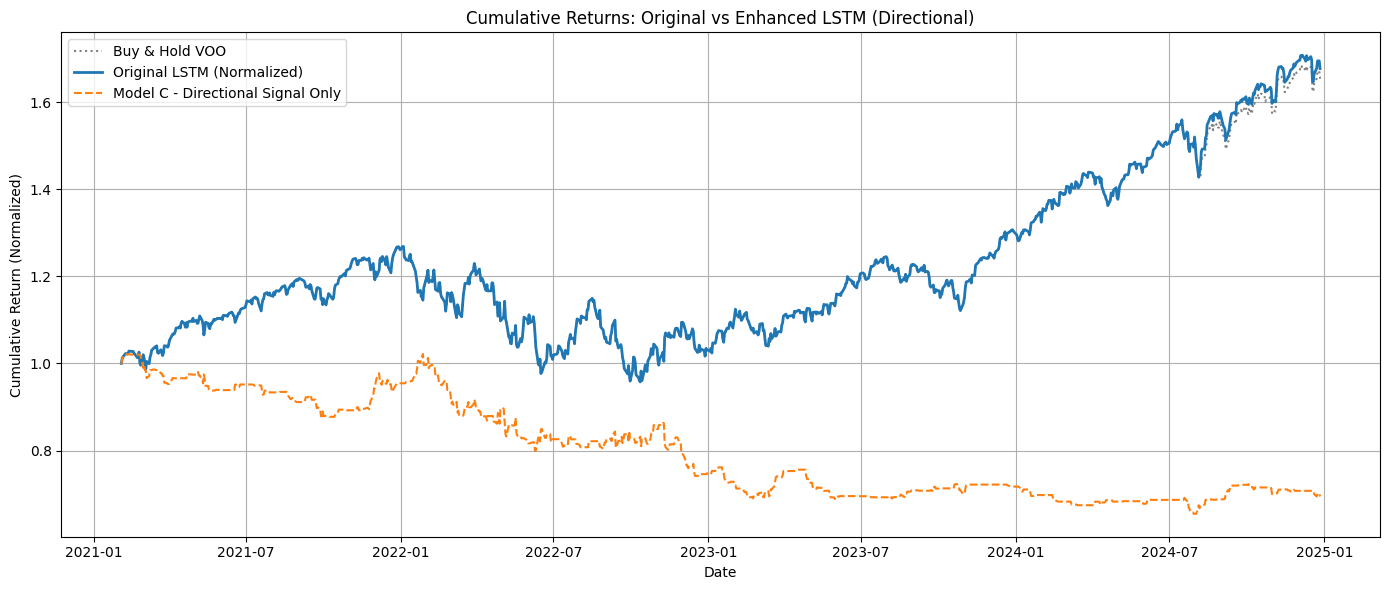

In [47]:
# --- Step 1: Compute VIX prediction change ---
vix_pred_diff_c = pd.Series(y_pred_c, index=df_lstm_all.index[-len(y_pred_c):]).diff().dropna()

# --- Step 2: Dynamic threshold based on distribution ---
lower, upper = np.percentile(vix_pred_diff_c, [20, 80])

signals_c = pd.Series(
    np.where(vix_pred_diff_c < lower, 1,  # Long on VIX falling
             np.where(vix_pred_diff_c > upper, -1, 0)),
    index=vix_pred_diff_c.index
)

# --- Step 3: Align to SPY or VOO returns ---
returns = df['VOO'].pct_change().reindex(signals_c.index).fillna(0)
strategy_returns_c = signals_c * returns
strategy_returns_c = strategy_returns_c.clip(lower=-0.1, upper=0.1)  # safety cap

# --- Step 4: Cumulative Returns ---
cumulative_returns_c = (1 + strategy_returns_c).cumprod()

# Save for next charting block if needed:
signals_model_c = signals_c.copy()
strategy_returns_model_c = strategy_returns_c.copy()
cumulative_returns_model_c = cumulative_returns_c.copy()

# --- Optional quick summary ---
print("Signal distribution:\n", signals_c.value_counts())
print("Cumulative return end value:", cumulative_returns_c.iloc[-1])

# --- Normalize original LSTM to start at 1 ---
aligned_original_lstm = df_strategy['Cumulative_Strategy_Returns_LSTM']
aligned_original_lstm = aligned_original_lstm.reindex(cumulative_returns_model_c.index).dropna()
aligned_original_lstm /= aligned_original_lstm.iloc[0]

# --- Recompute Buy & Hold baseline (normalize too) ---
buy_hold_returns = (1 + df['VOO'].pct_change().reindex(cumulative_returns_model_c.index).fillna(0)).cumprod()
buy_hold_returns /= buy_hold_returns.iloc[0]

# --- Plot again ---
plt.figure(figsize=(14, 6))
plt.plot(buy_hold_returns, label='Buy & Hold VOO', linestyle=':', color='gray')
plt.plot(aligned_original_lstm, label='Original LSTM (Normalized)', linewidth=2)
plt.plot(cumulative_returns_model_c, label='Model C - Directional Signal Only', linestyle='--')
plt.title("Cumulative Returns: Original vs Enhanced LSTM (Directional)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


    Upper  Lower  Cumulative Return    Sharpe  Volatility
51     11     -4           3.229689  1.244028    0.191955
41     10     -4           3.229689  1.244028    0.191955
8       5     -2           3.359811  1.241884    0.196801
11      6     -4           3.209233  1.240359    0.191958
32      9     -4           2.939363  1.187129    0.192007


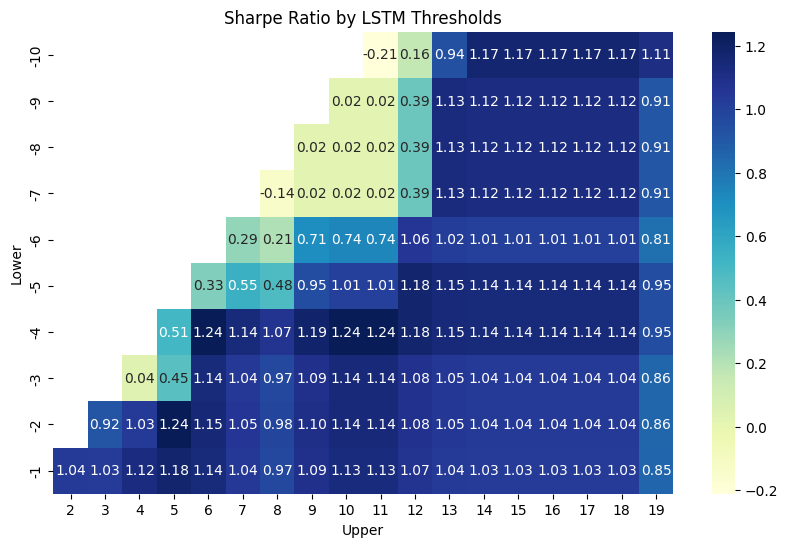

In [49]:
# Define grid of thresholds
upper_range = np.arange(1, 20, 1)   # 5 to 15
lower_range = np.arange(-10, 0, 1)   # -5 to -1

results = []

# Ensure you're working with a copy
df_search = df_strategy.copy()

for upper in upper_range:
    for lower in lower_range:
        # Skip illogical combinations
        if upper <= abs(lower):
            continue

        # Generate signal
        positions = [0]
        for i in range(1, len(df_search)):
            prev = df_search['LSTM_Prediction'].iloc[i-1]
            curr = df_search['LSTM_Prediction'].iloc[i]

            if curr > prev + upper:
                positions.append(-1)
            elif curr < prev + lower:
                positions.append(1)
            else:
                positions.append(positions[-1])  # hold

        df_search['Grid_Position'] = positions

        # Calculate strategy returns
        df_search['Grid_Returns'] = df_search['VOO'].pct_change() * df_search['Grid_Position'].shift(1)
        df_search['Grid_Returns'] = df_search['Grid_Returns'].fillna(0)

        # Evaluate performance
        cumulative_return = (1 + df_search['Grid_Returns']).prod() - 1
        annualized_vol = df_search['Grid_Returns'].std() * np.sqrt(252)
        sharpe = df_search['Grid_Returns'].mean() / df_search['Grid_Returns'].std() * np.sqrt(252)

        results.append({
            'Upper': upper,
            'Lower': lower,
            'Cumulative Return': cumulative_return,
            'Sharpe': sharpe,
            'Volatility': annualized_vol
        })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Sharpe', ascending=False)


# Top results
print(results_df.head(5))

# Heatmap (Sharpe)
pivot = results_df.pivot(index='Lower', columns='Upper', values='Sharpe')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Sharpe Ratio by LSTM Thresholds")
plt.show()


In [50]:
# --- Step 1: Apply Optimal Thresholds ---
upper_opt = 2
lower_opt = -1

positions_opt = [0]
for i in range(1, len(df_strategy)):
    prev = df_strategy['LSTM_Prediction'].iloc[i-1]
    curr = df_strategy['LSTM_Prediction'].iloc[i]

    if curr > prev + upper_opt:
        positions_opt.append(-1)
    elif curr < prev + lower_opt:
        positions_opt.append(1)
    else:
        positions_opt.append(positions_opt[-1])

df_strategy['Position_LSTM_Optimized'] = positions_opt

# --- Step 2: Strategy Returns ---
returns_opt = df_strategy['VOO'].pct_change().fillna(0)
strategy_returns_opt = returns_opt * df_strategy['Position_LSTM_Optimized'].shift(1).fillna(0)
cumulative_returns_opt = (1 + strategy_returns_opt).cumprod()

# Normalize for comparison
cumulative_returns_opt /= cumulative_returns_opt.iloc[0]
buy_hold = (1 + returns_opt).cumprod()
buy_hold /= buy_hold.iloc[0]



Strategy                 Return   Volatility     Sharpe    Max Drawdown
Buy & Hold               136.21%        19.85%       0.76           44.93%
Original LSTM            284.52%        19.68%       1.14           72.13%
Optimized LSTM           237.53%        19.82%       1.04           80.14%


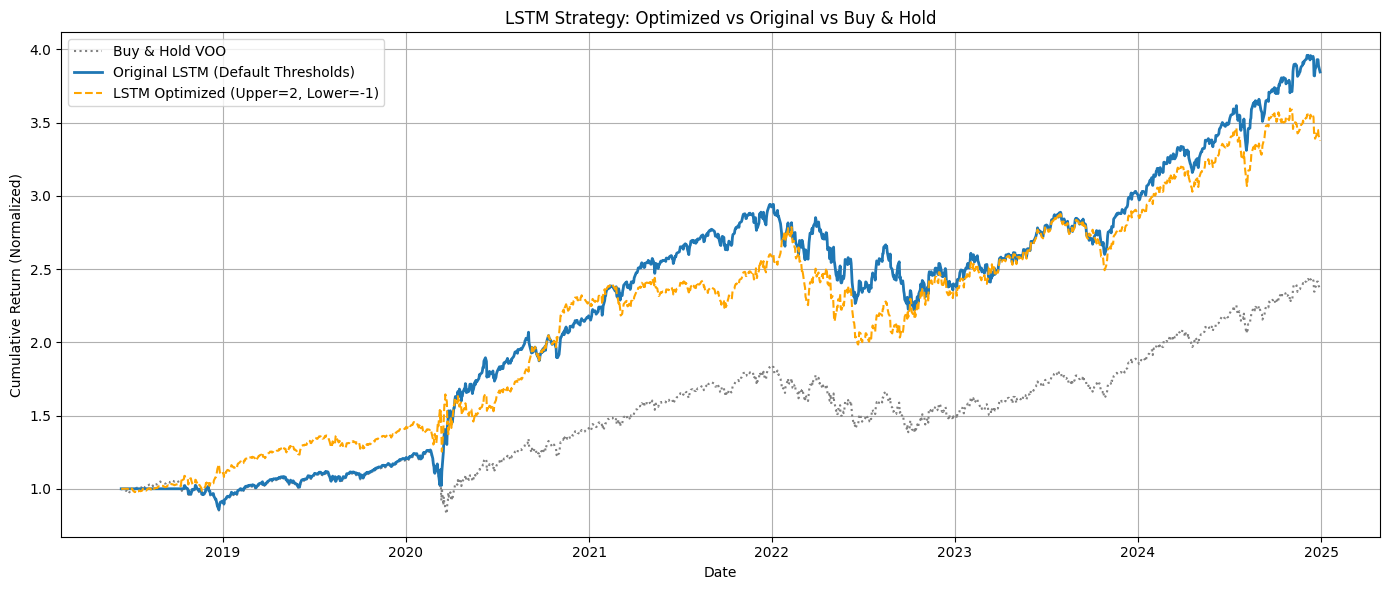

In [51]:
# --- Step 1: Strategy Returns ---
returns_opt = df_strategy['VOO'].pct_change().fillna(0)
buy_hold_returns = returns_opt.copy()
lstm_returns_default = df_strategy['Strategy_Returns_LSTM'].fillna(0)
lstm_returns_opt = returns_opt * df_strategy['Position_LSTM_Optimized'].shift(1).fillna(0)

# --- Step 2: Cumulative Returns ---
cumulative_buy_hold = (1 + buy_hold_returns).cumprod()
cumulative_buy_hold /= cumulative_buy_hold.iloc[0]

cumulative_lstm_default = df_strategy['Cumulative_Strategy_Returns_LSTM'].dropna()
cumulative_lstm_default /= cumulative_lstm_default.iloc[0]

cumulative_lstm_opt = (1 + lstm_returns_opt).cumprod()
cumulative_lstm_opt /= cumulative_lstm_opt.iloc[0]

# --- Step 3: Define Performance Metric Function ---
def compute_metrics(returns):
    returns = returns.dropna()
    cumulative_return = (1 + returns).prod() - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative.cummax() - cumulative).max()
    return cumulative_return, annualized_vol, sharpe, drawdown

# --- Step 4: Compute Metrics ---
metrics = {
    'Buy & Hold': compute_metrics(buy_hold_returns),
    'Original LSTM': compute_metrics(lstm_returns_default),
    'Optimized LSTM': compute_metrics(lstm_returns_opt)
}

# --- Step 5: Print Results ---
print(f"{'Strategy':<20} {'Return':>10} {'Volatility':>12} {'Sharpe':>10} {'Max Drawdown':>15}")
for name, (ret, vol, sharpe, dd) in metrics.items():
    print(f"{name:<20} {ret*100:10.2f}% {vol*100:12.2f}% {sharpe:10.2f} {dd*100:15.2f}%")

# --- Step 6: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(cumulative_buy_hold, label='Buy & Hold VOO', linestyle=':', color='gray')
plt.plot(cumulative_lstm_default, label='Original LSTM (Default Thresholds)', linewidth=2)
plt.plot(cumulative_lstm_opt, label=f'LSTM Optimized (Upper={upper_opt}, Lower={lower_opt})', linestyle='--', color='orange')

plt.title("LSTM Strategy: Optimized vs Original vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
def compute_metrics(returns, positions=None, name='Strategy'):
    returns = returns.dropna()
    cumulative_return = (1 + returns).prod() - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = returns.mean() / returns.std() * np.sqrt(252)
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative.cummax() - cumulative).max()
    trade_count = (positions.diff().fillna(0) != 0).sum() if positions is not None else np.nan

    return {
        'Strategy': name,
        'Total Return': f"{cumulative_return*100:.2f}%",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Max Drawdown': f"{drawdown*100:.2f}%",
        'Trades': trade_count
    }

# --- Define strategy returns and positions ---
metrics_all = []

metrics_all.append(compute_metrics(buy_hold_returns, name="Buy & Hold"))
metrics_all.append(compute_metrics(df_strategy['Strategy_Returns_LSTM'],
                                   df_strategy['Position_LSTM'],
                                   name="Original LSTM"))
metrics_all.append(compute_metrics(strategy_returns_opt,
                                   df_strategy['Position_LSTM_Optimized'],
                                   name="LSTM Optimized (Grid Search)"))
metrics_all.append(compute_metrics(strategy_returns_model_c,
                                   signals_model_c,
                                   name="Multivariate LSTM (Model C)"))
metrics_all.append(compute_metrics(df['VOO'].pct_change() * df['Position_GARCH'].shift(1),
                                   df['Position_GARCH'],
                                   name="GARCH Signal Only"))

# --- Compile and display ---
summary_df = pd.DataFrame(metrics_all)
summary_df.set_index('Strategy', inplace=True)
summary_df.index.name = None
print(summary_df)


                             Total Return Sharpe Ratio Max Drawdown  Trades
Buy & Hold                        136.21%         0.76       44.93%     NaN
Original LSTM                     284.52%         1.14       72.13%    13.0
LSTM Optimized (Grid Search)      237.53%         1.04       80.14%   160.0
Multivariate LSTM (Model C)       -30.54%        -0.72       36.69%   425.0
GARCH Signal Only                  88.79%         0.82       19.37%   468.0
